# Summary

## Global Explanations
The most important feature for both classifiers is LSTAT, and it is the main reason for the differences as well. According to the individual SHAP explanations, there is a natural order to the three labels, where LSTAT's increasing influence is highest for each label in a different value range. The relatively low importance of the difference classes $(2,0)$ and $(0,2)$, and the fact that no actual instances are classified like that indicate this as well. I found out, that the difference classes $(0,1)$ and $(1,0)$ have their peak increasing effect in the range of LSTAT between approx. 11 and 20, $(1,2)$ and $(2,1)$ in the range between approx. 5 and 10.

## Local Explanations

**Differences: A predicts 0 and B 1**

These instances can be characterized by:
- a high value of LSTAT (>11)
- low value of ZN (=0)
- high value of INDUS (>4)
- low CRIM values (<14)
- RM values between 5 and 7
- low DIS values (<6.4)
- high AGE values (mostly 1 and 2, 2 being overrepresented)

Generally, for instances classified differently with these characteristics, the boundary where A changes its prediction to conclude with B is at LSTAT=10.2. Another boundary is at ZN=6. But there are instances with the same characteristics for which A and B predict equal labels. The boundary where B changes its prediction to conclude with A is at LSTAT=19.2, differences occur below this boundary. Another boundary is at CRIM=6.2, difference occur below this boundary.

**Differences: A predicts 1 and B 2**

These instances can be characterized by:
- a low LSTAT value (<11.5)
- low ZN value (=0)
- low INDUS value (<19.5)
- low CRIM value (<9.3)

LSTAT alone is one reason why instances with these characteristics are classified differently, because outside this range, B changes its prediction to conclude with A. INDUS is another reason, outside this range B too changes its prediction to conclude with A. But there are instances with these characteristics for which A and B predict equal labels as well. What differentiates them is that the differences occur between LSTAT 4.5 and 11.5, below A changes its prediction to conclude with B and above B changes its prediction to conclude with A. Another boundary is at CRIM=6.2, differences occur below this boundary and above it, B changes its prediction to conclude with A.

B changes its prediction to conclude with A if LSTAT was higher (≥11.5). But there are instances with the same characteristics for which A and B predict equal labels. What differentiates them is that A changes its prediction to conclude with B if LSTAT was lower (≤4.5) or if ZN was higher (≥90).

**Differences: A predicts 2 and B 1**

These instances can be characterized by two different types:

First type:
- low LSTAT value (≤13)
- low INDUS value (≤18.1)
- low CRIM value (<5.9)
- high RM value (>5.7)
- low AGE value (2 is underrepresented, 0 overrepresented)

Generally, for instances classified differently with these characteristics, A changes its prediction to conclude with B if LSTAT was higher (>13) or INDUS was higher (≥19). But there are instances with the same characteristics for which A and B predict equal labels. What differentiates them is that B changes its prediction to conclude with A if LSTAT was lower (≤8.5) or if ZN was higher (≥62); or that A changes its prediction to conclude with B if LSTAT was higher (≥9.1).

Second type:
- low LSTAT value (<9.6)
- low ZN value (=0)
- INDUS values between 11.9 and 19.6
- low CRIM value (<9.3)
- high TAX value (≥273)
- low DIS value (<3.5)
- high AGE value (1 is underrepresented, 0 not present)

Generally, for instances classified differently with these characteristics, A changes its prediction to conclude with B if LSTAT was higher (≥9.6) or ZN was higher (≥83). But there are instances with the same characteristics for which A and B predict equal labels. What differentiates them is that B changes its prediction to conclude with A if LSTAT was lower (≤5.9); or that A changes its prediction to conclude with B if LSTAT was higher (≥7.5). To find a different reason besides this feature, I needed to dig a little bit deeper. First, if INDUS is particularly low (<17) then B changes its prediction to conclude with A if INDUS was higher than that. Second, if RM is low (<4.4), then B changes its prediction to conclude with A if RM was higher than that.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from kneed import KneeLocator
import joblib
shap.initjs()
task_name = '02'

In [3]:
try:
    with open(task_name + '.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    with open(task_name + '.comparer', 'rb') as f:
        comparer = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
except FileNotFoundError:
    pass

# Setup Task

In [102]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,2.720010,12.841063,11.718208,0.572581,6.511388,1.304878,3.501706,9.346908,403.132604,18.125578,11.736981
std,6.388147,25.552540,7.290396,0.125307,0.889747,0.813494,2.007156,8.493772,165.416533,2.524334,7.372550
min,0.009060,0.000000,1.210000,0.389000,3.561000,0.000000,1.137912,1.000000,188.000000,13.000000,1.763949
25%,0.099321,0.000000,4.243588,0.462112,5.882000,1.000000,1.967365,4.000000,273.000000,15.707491,5.008267
50%,0.540032,0.000000,9.900000,0.544000,6.315500,2.000000,2.866600,5.000000,362.186013,18.571912,9.950000
75%,3.181873,20.000000,18.100000,0.638740,7.134552,2.000000,4.621654,8.000000,461.000000,20.200000,17.091674
max,73.534100,100.000000,25.650000,0.871000,8.638029,2.000000,10.710300,24.000000,679.526743,22.000000,36.980000


In [103]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

In [7]:
clf_a = joblib.load('model_A.joblib')
clf_b = joblib.load('model_B.joblib')
comparer = ModelComparer(clf_a, clf_b, feature_names)
with open(task_name + '.comparer', 'wb') as f:
    pickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


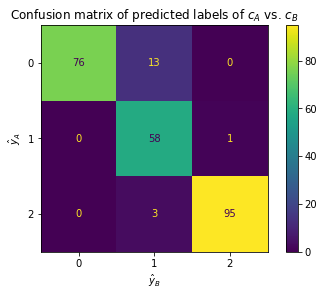

In [5]:
comparer.plot_confusion_matrix(X)

In [ ]:
%%time
masker = Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [ ]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Feature importances are pretty similar, with RAD being less important to A, AGE less important to B. NOX has nearly no importance to neither classifier.

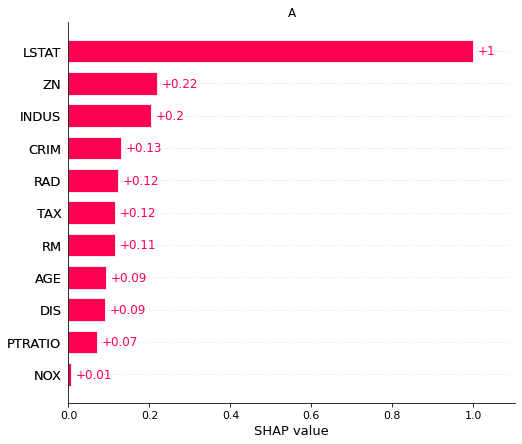

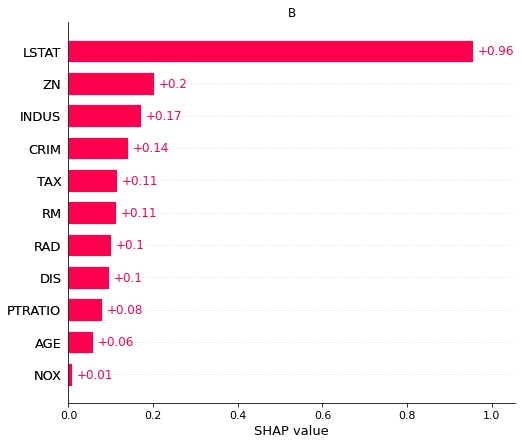

In [108]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [109]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)

In [110]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects_comparison(color=is_pred_diff,
                                    **{'A': explanations.indiv.log_odds.A[:, [feature_idx]],
                                       'B': explanations.indiv.log_odds.B[:, [feature_idx]]})
it = iter(feature_order)

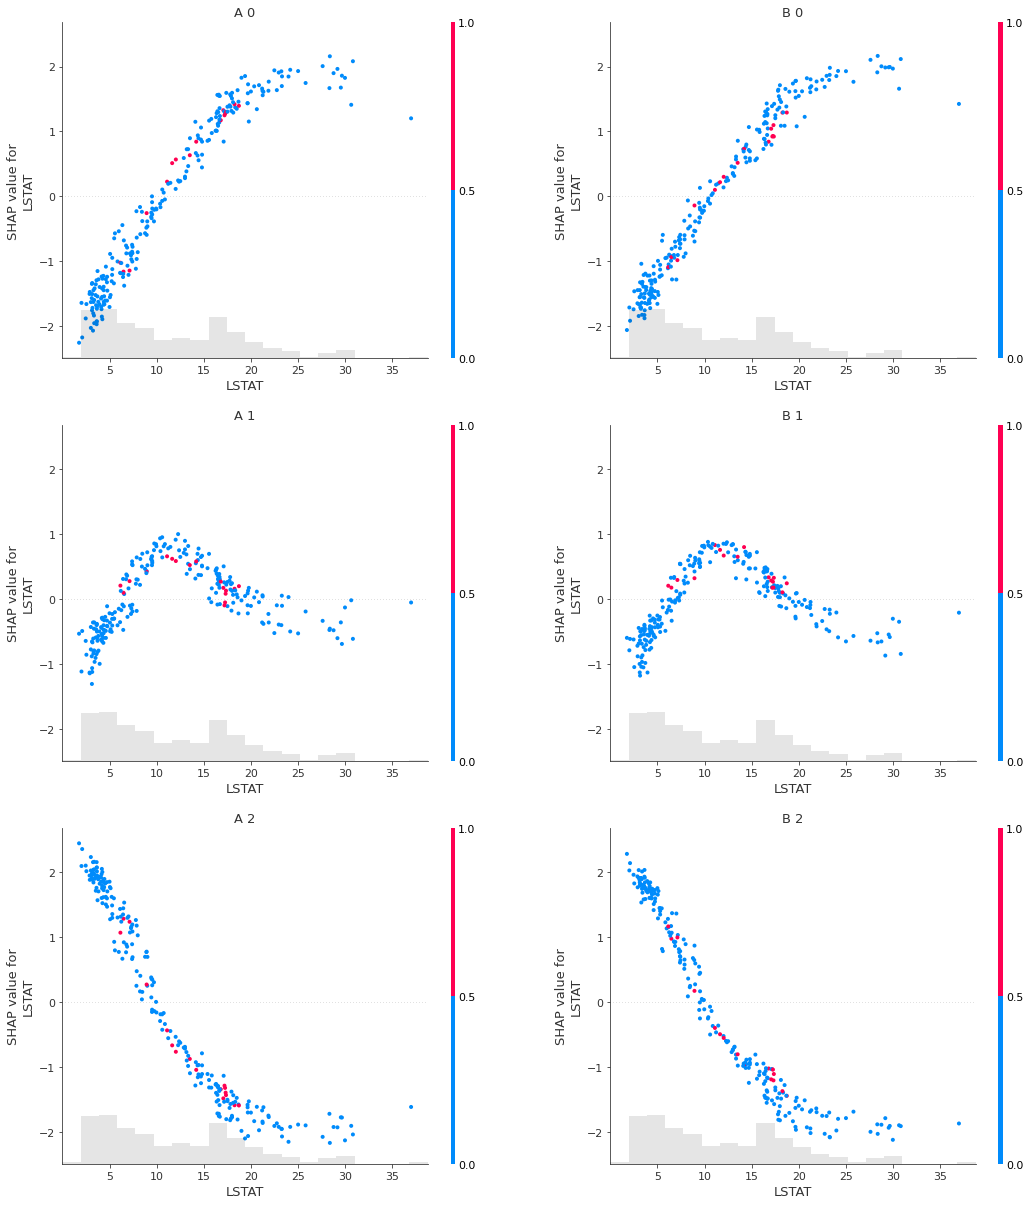

In [111]:
plot_next_feature()

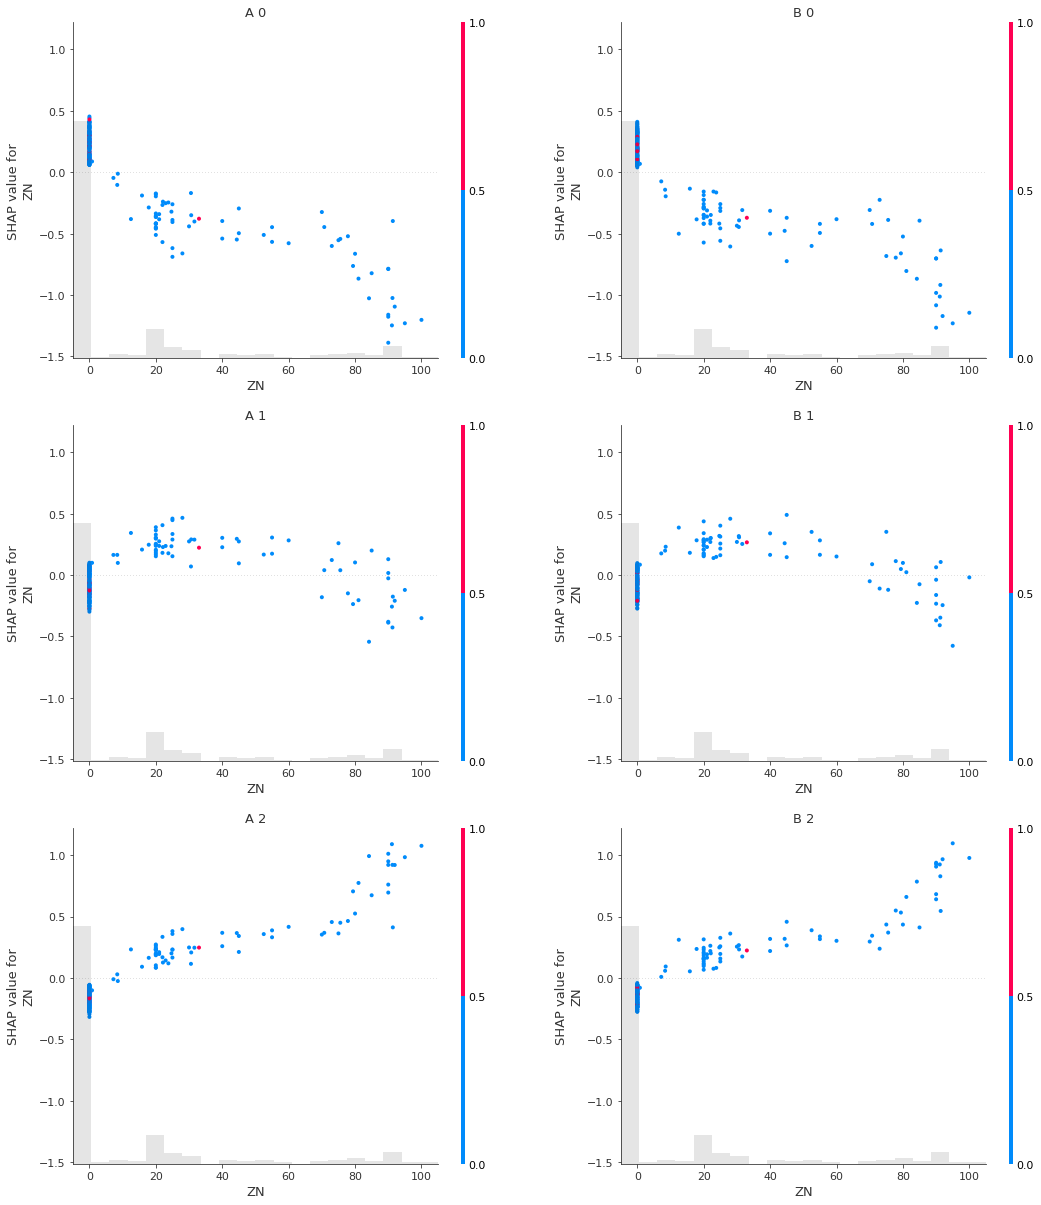

In [112]:
plot_next_feature()

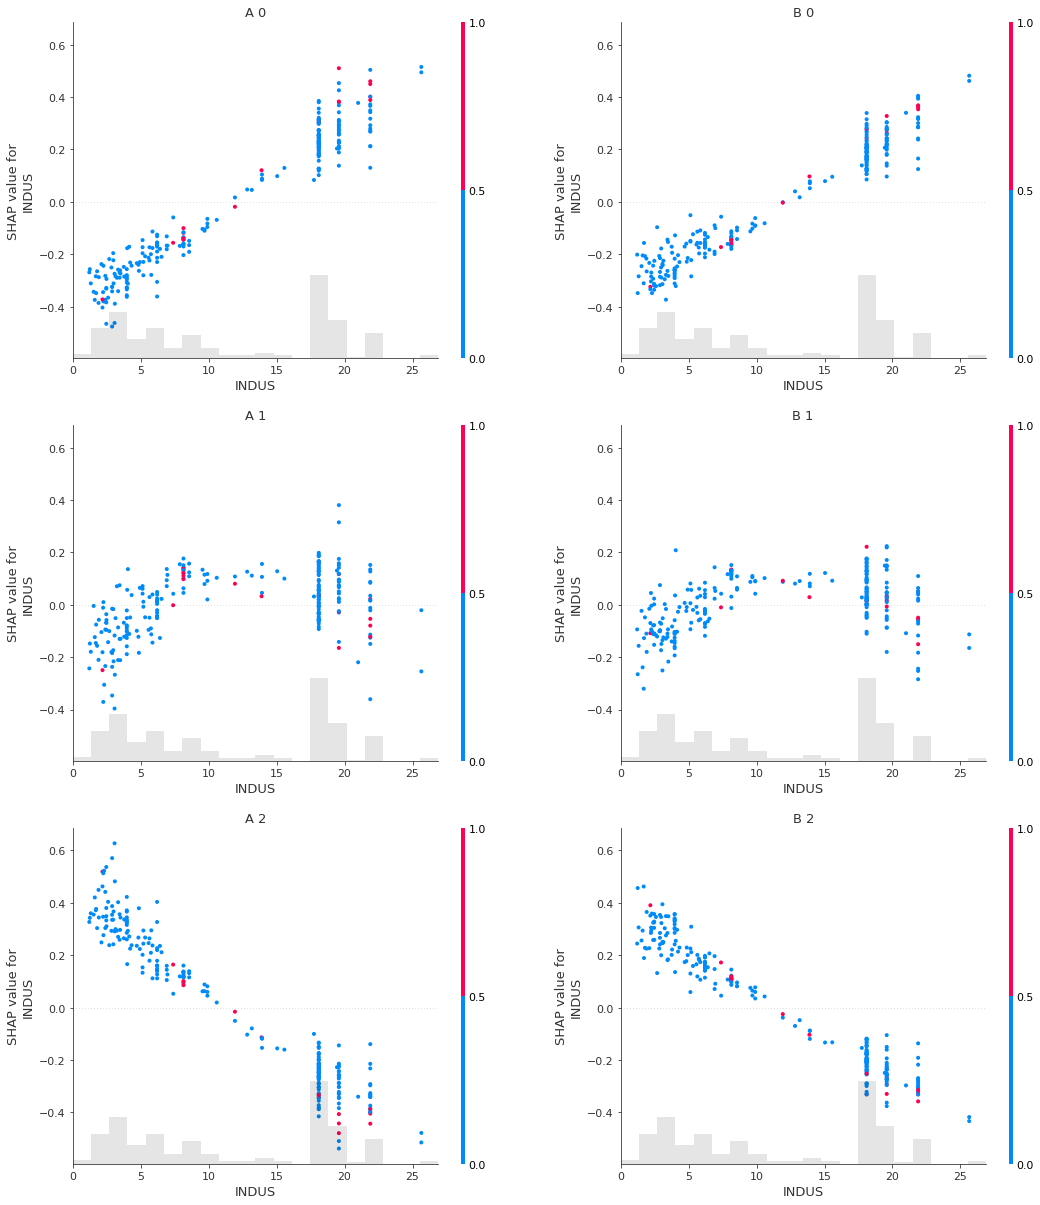

In [113]:
plot_next_feature()

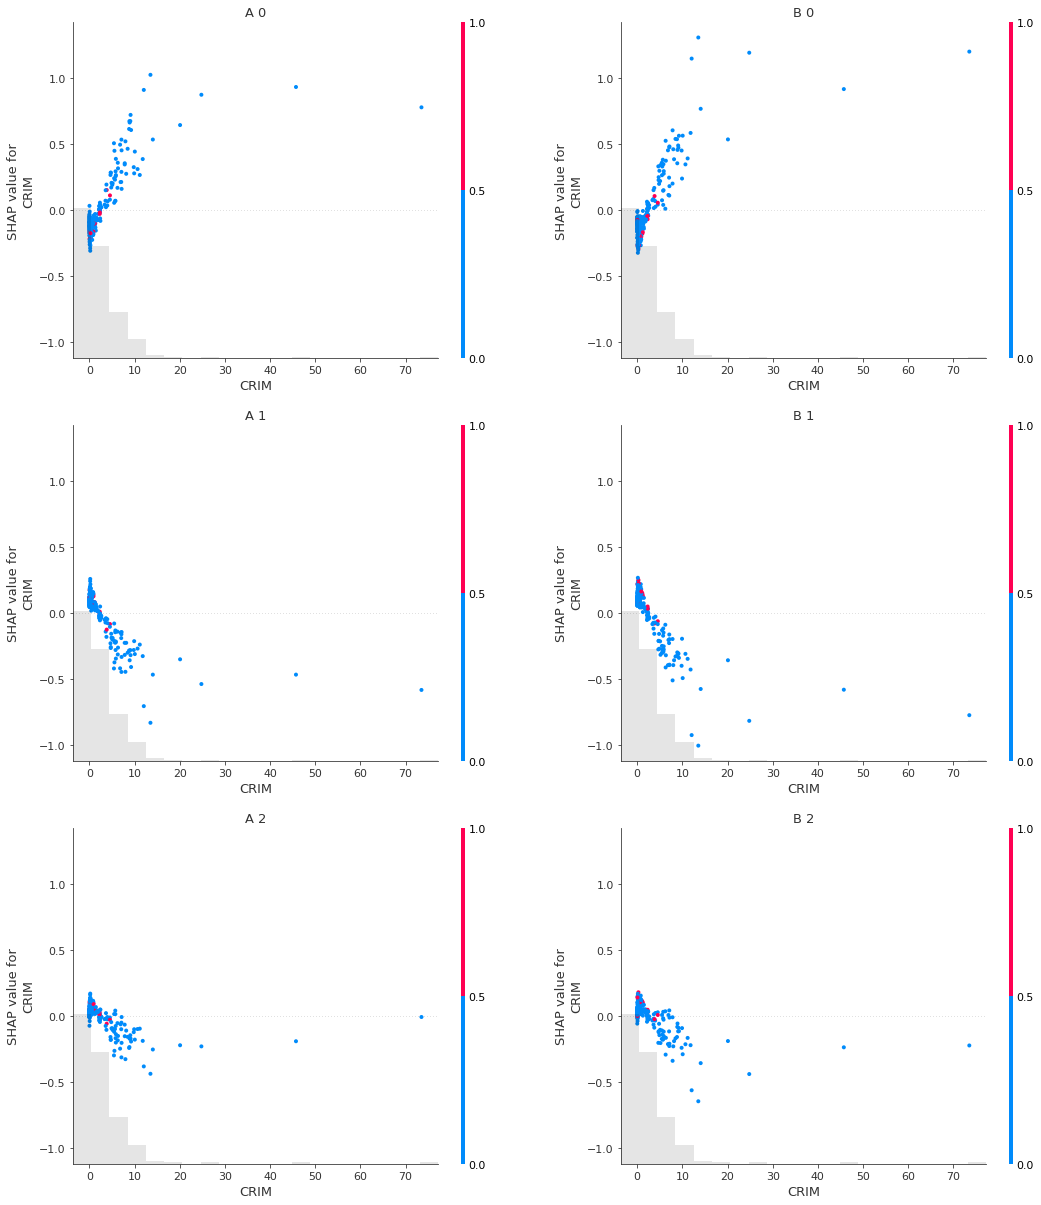

In [114]:
plot_next_feature()

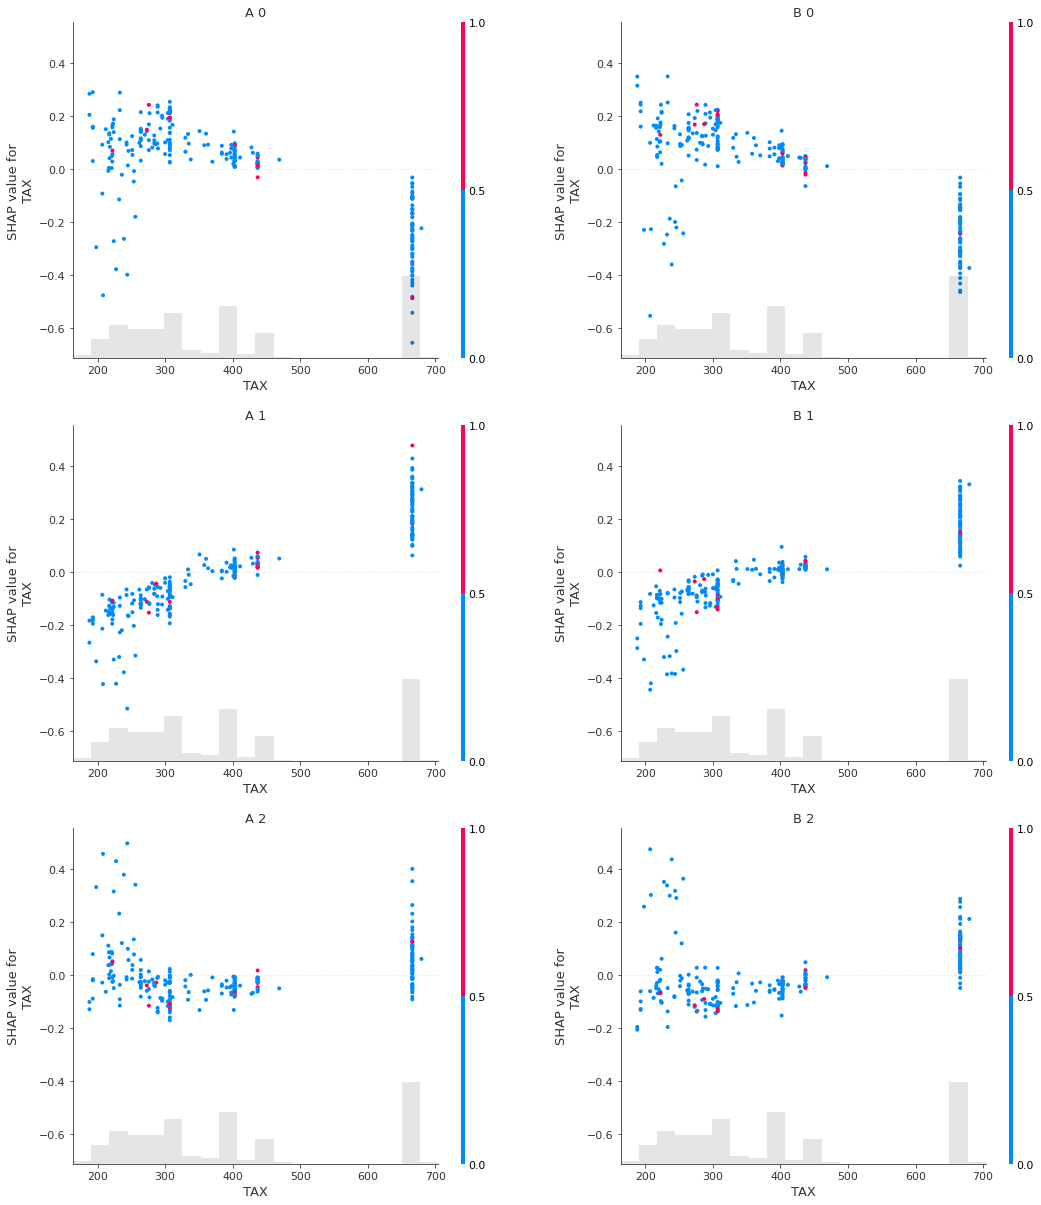

In [115]:
plot_next_feature()

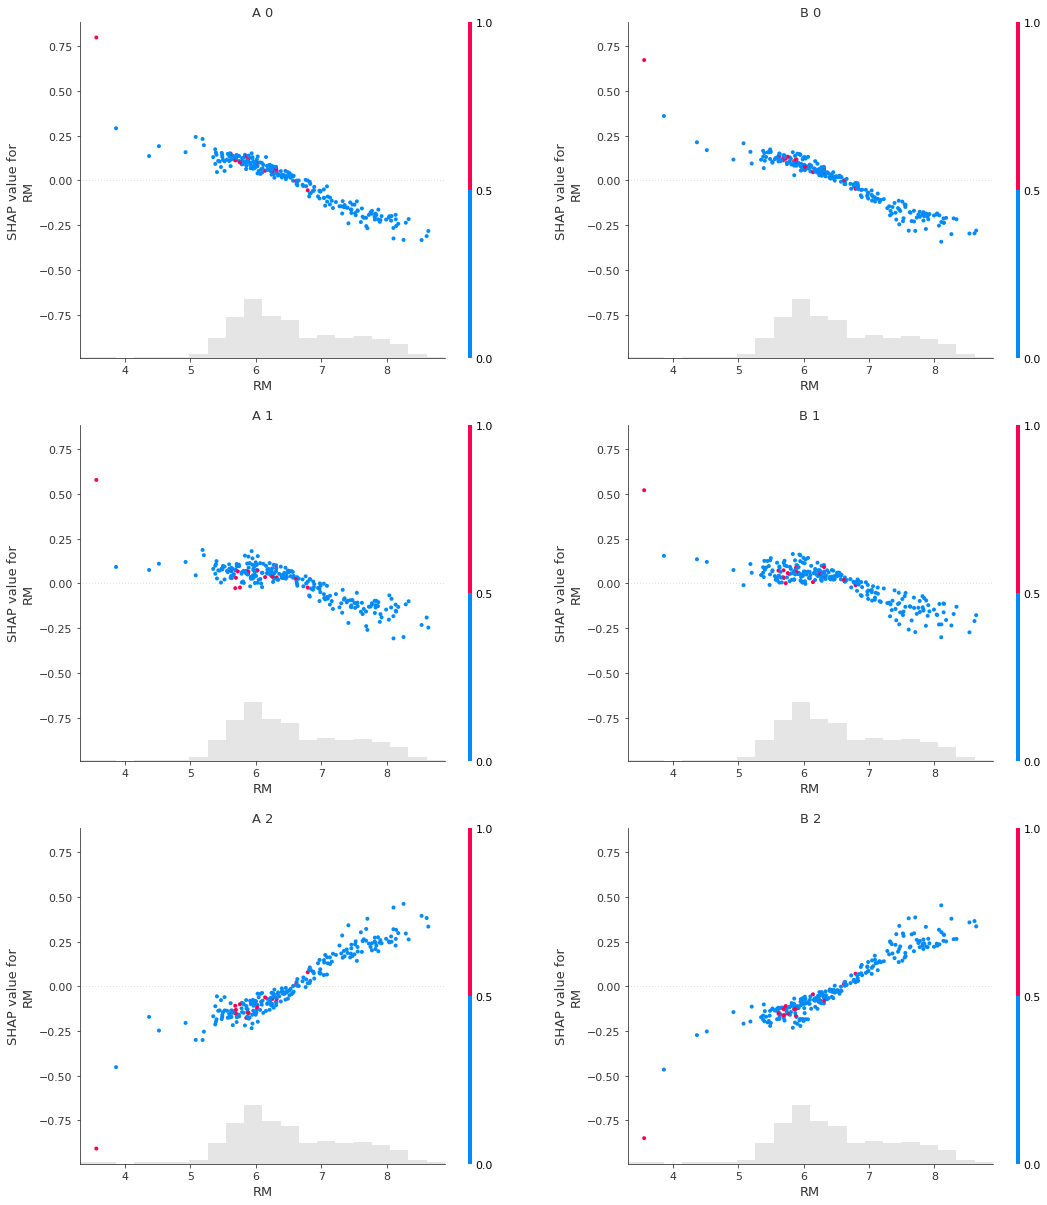

In [116]:
plot_next_feature()

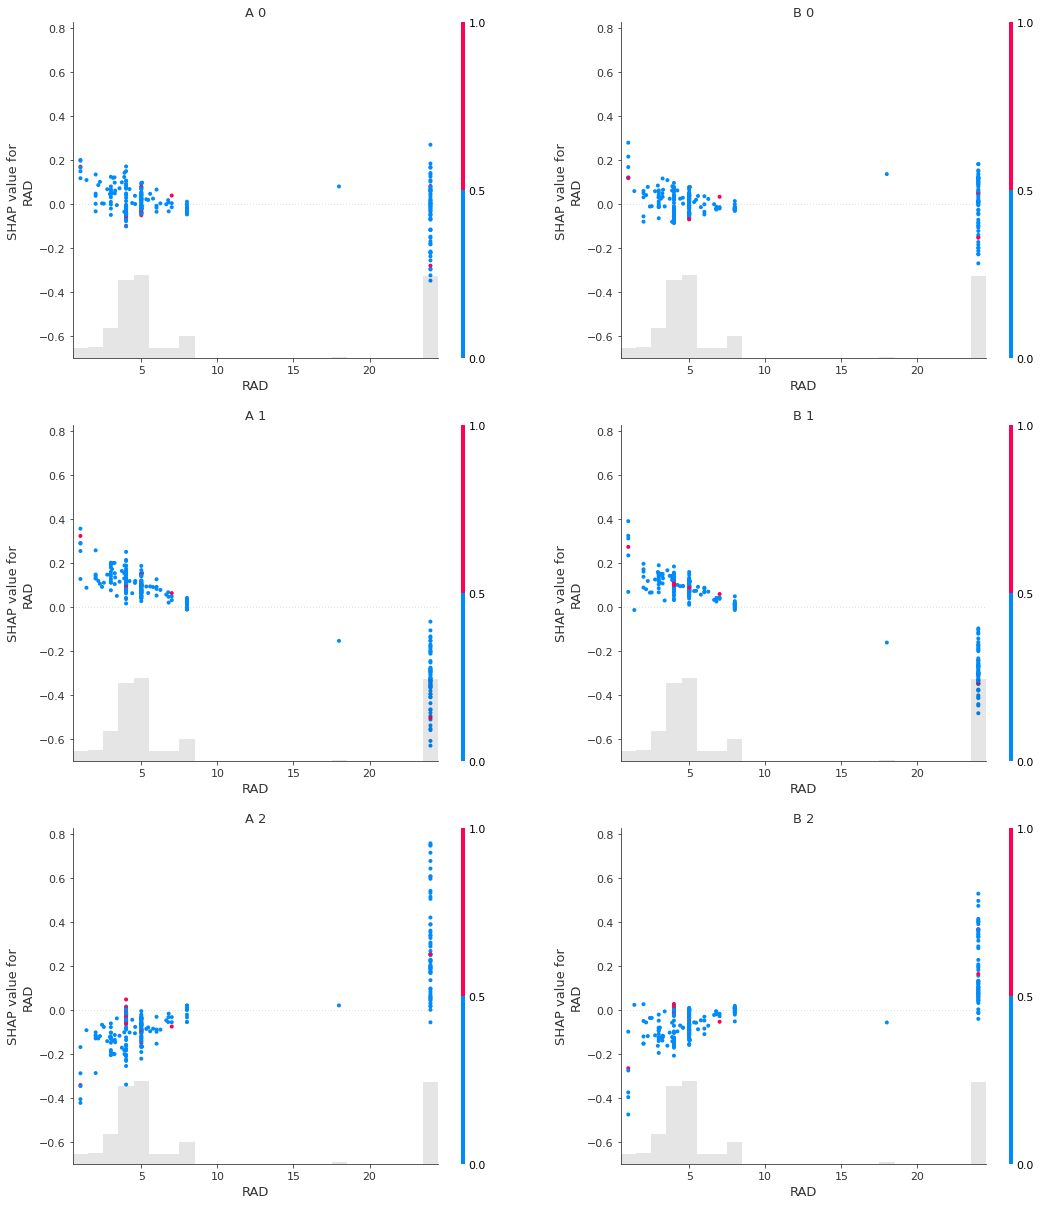

In [117]:
plot_next_feature()

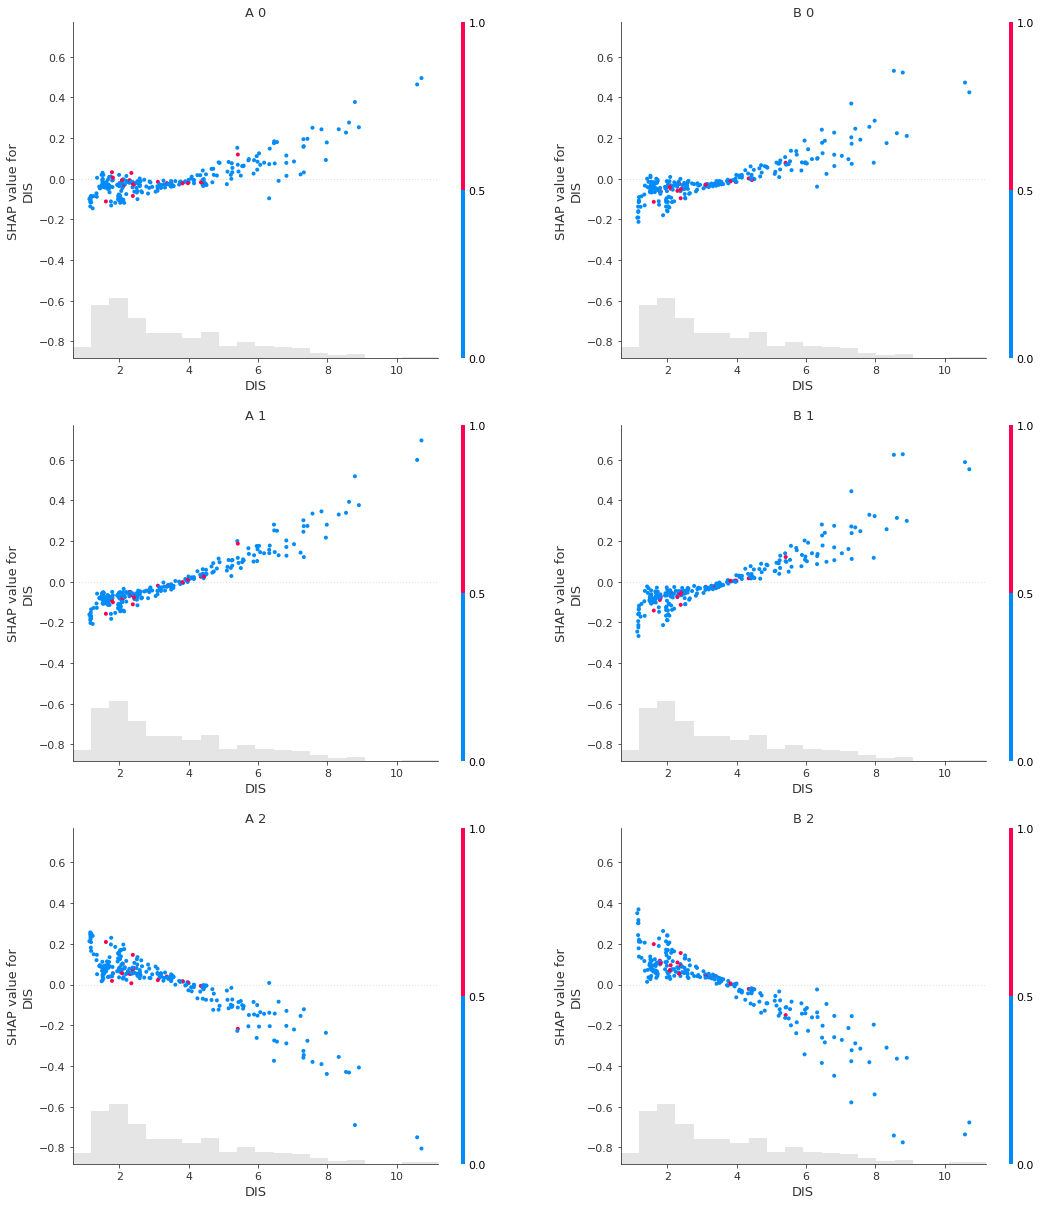

In [118]:
plot_next_feature()

AGE has more differences than the other features. It has linear effects for both classifiers, but with opposite directions.

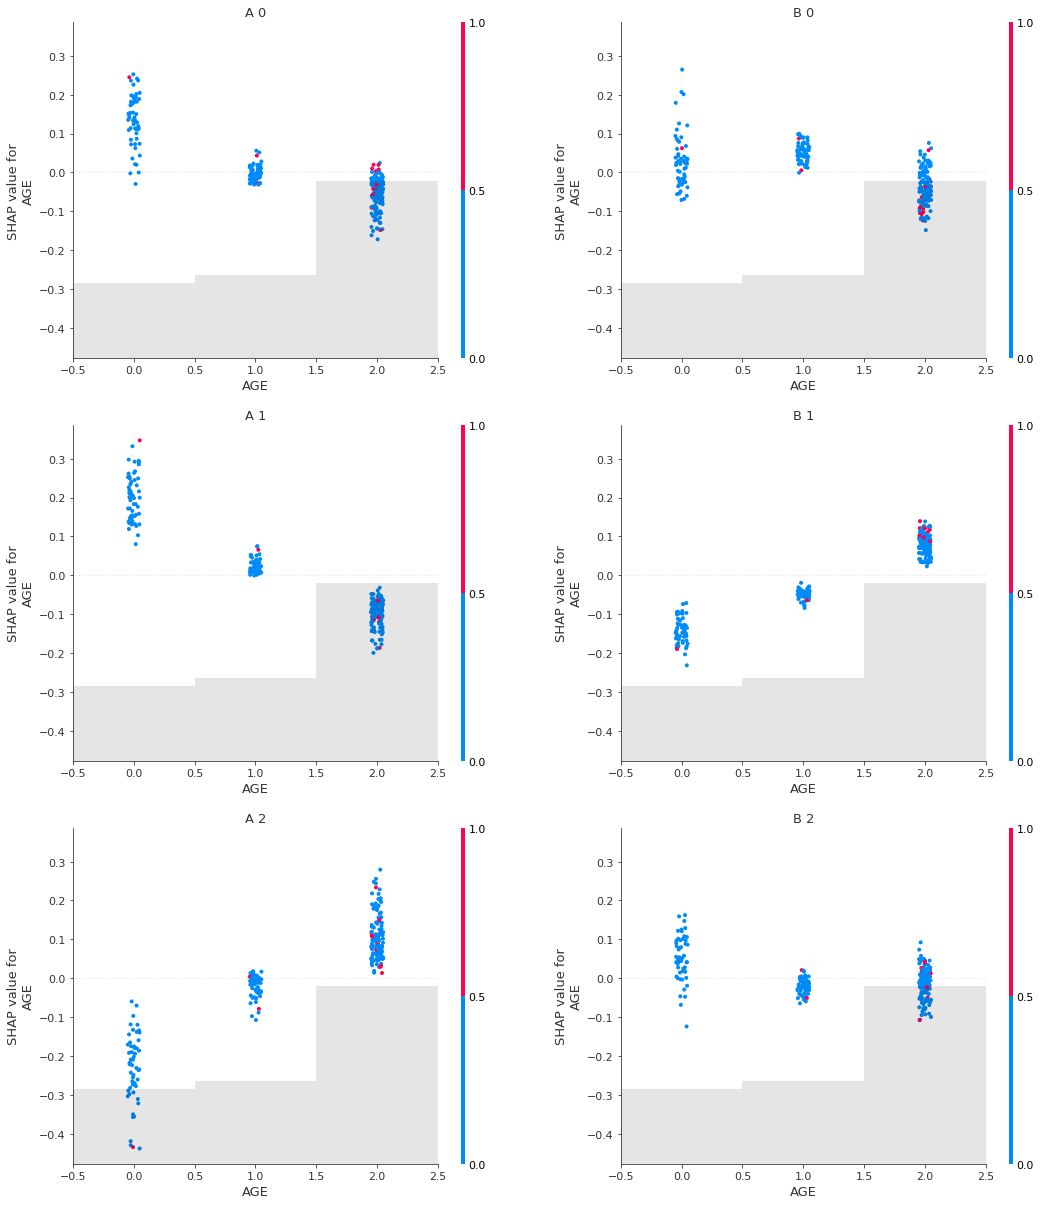

In [119]:
plot_next_feature()

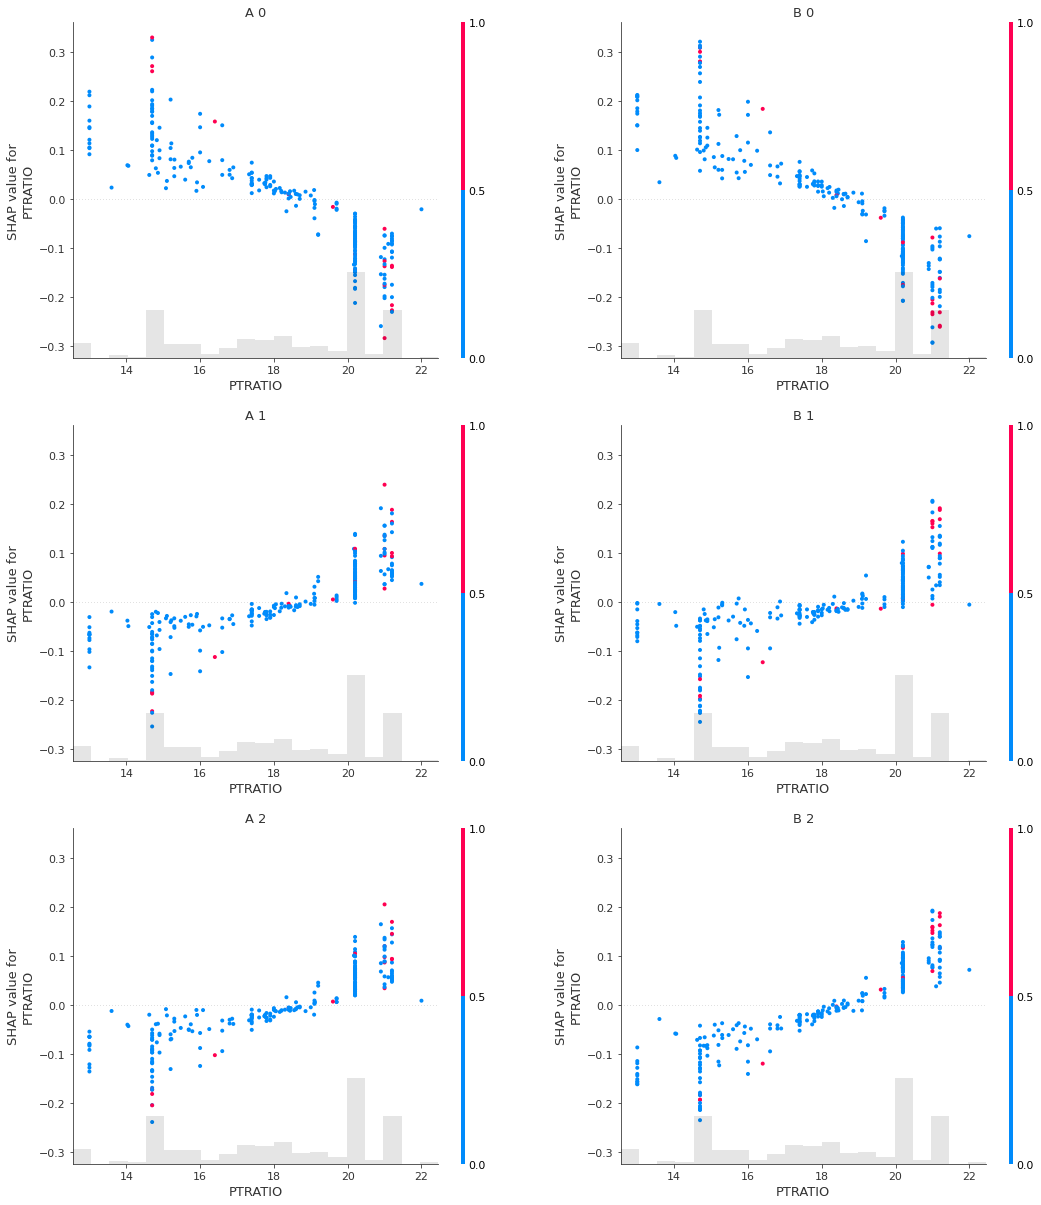

In [120]:
plot_next_feature()

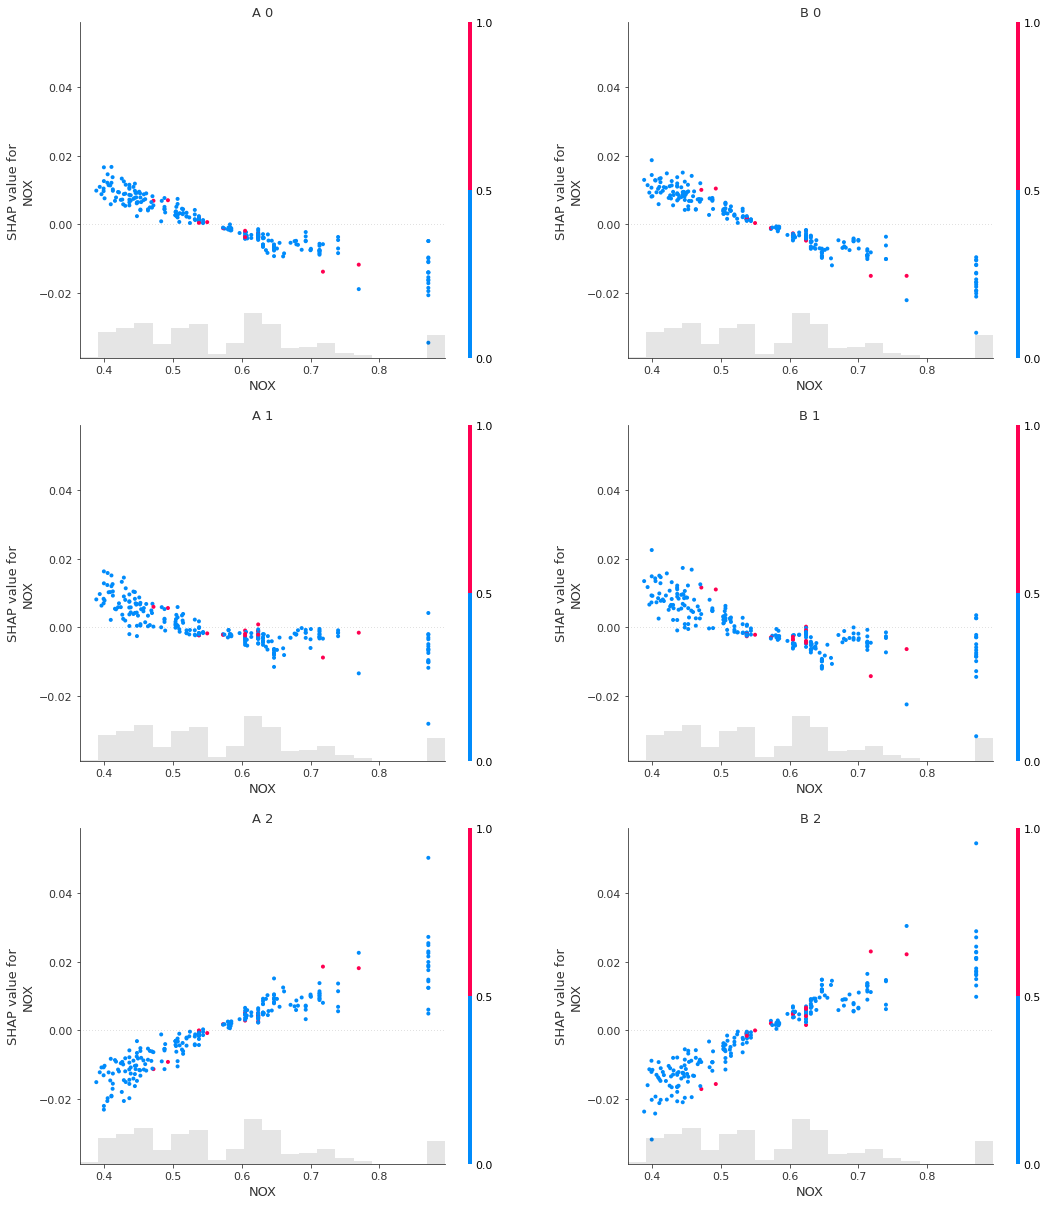

In [121]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

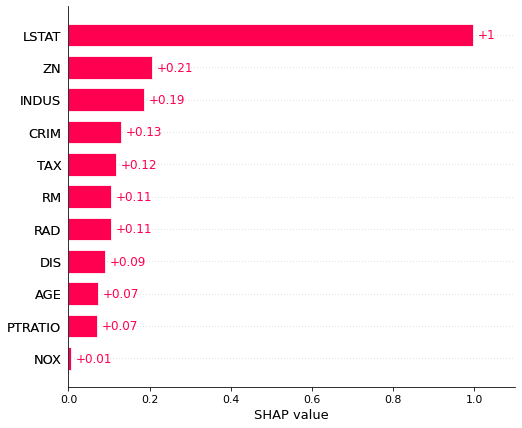

In [11]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
global_feature_order = feature_order
plot_feature_importance_bar(feature_importances)

In [105]:
X.iloc[:, feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,11.736981,12.841063,11.718208,2.720010,403.132604,6.511388,9.346908,3.501706,1.304878,18.125578,0.572581
std,7.372550,25.552540,7.290396,6.388147,165.416533,0.889747,8.493772,2.007156,0.813494,2.524334,0.125307
min,1.763949,0.000000,1.210000,0.009060,188.000000,3.561000,1.000000,1.137912,0.000000,13.000000,0.389000
25%,5.008267,0.000000,4.243588,0.099321,273.000000,5.882000,4.000000,1.967365,1.000000,15.707491,0.462112
50%,9.950000,0.000000,9.900000,0.540032,362.186013,6.315500,5.000000,2.866600,2.000000,18.571912,0.544000
75%,17.091674,20.000000,18.100000,3.181873,461.000000,7.134552,8.000000,4.621654,2.000000,20.200000,0.638740
max,36.980000,100.000000,25.650000,73.534100,679.526743,8.638029,24.000000,10.710300,2.000000,22.000000,0.871000


In [106]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

The equality classes $(0,0)$ and $(2,2)$ have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

$(0,2)$ and $(2,0)$ have the least importances.

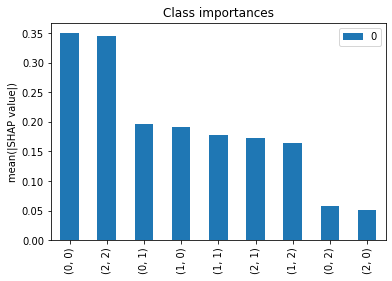

In [24]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [25]:
class_order = np.sort(class_order[:-2])

In [96]:
def plot_next_feature():
    feature_idx = next(it)
    # plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]], class_order=class_order)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[:4]], color=is_pred_diff)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[3:]], color=is_pred_diff)
it = iter(feature_order)

Difference classes $(0,1)$ and $(1,0)$ are at their peak between approx. 11 and 20, $(1,2)$ and $(2,1)$ in the range between approx. 5 and 10.

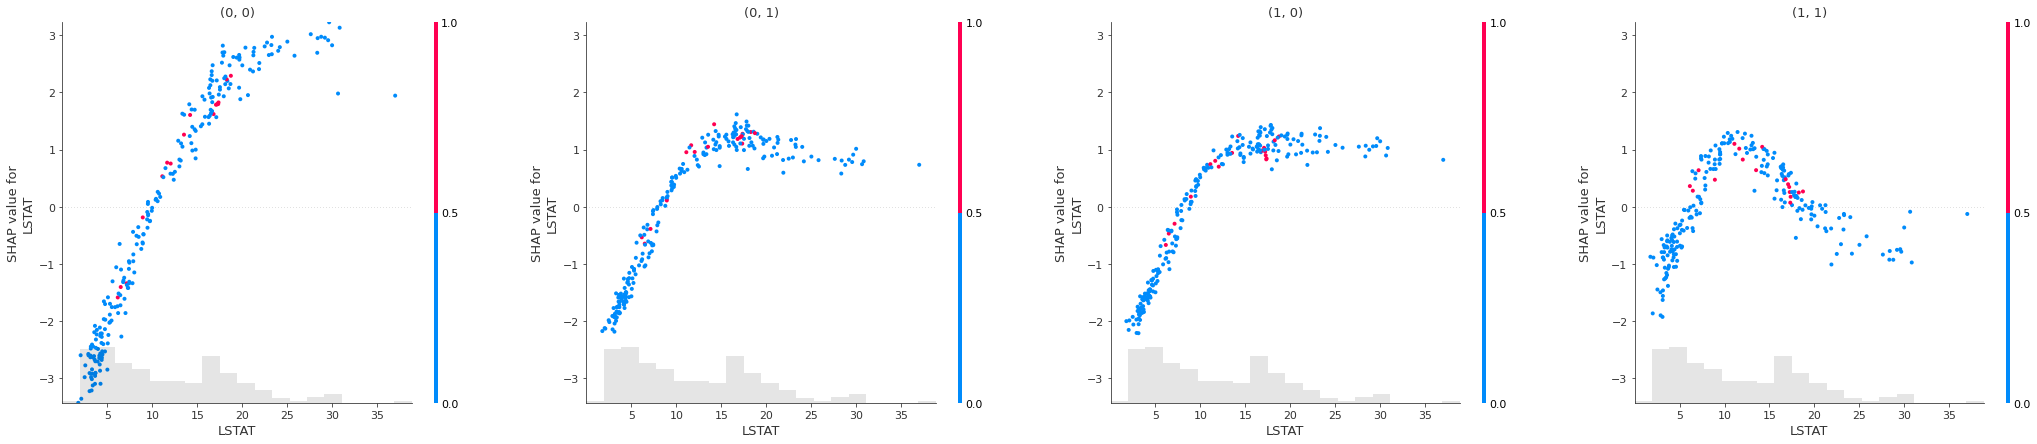

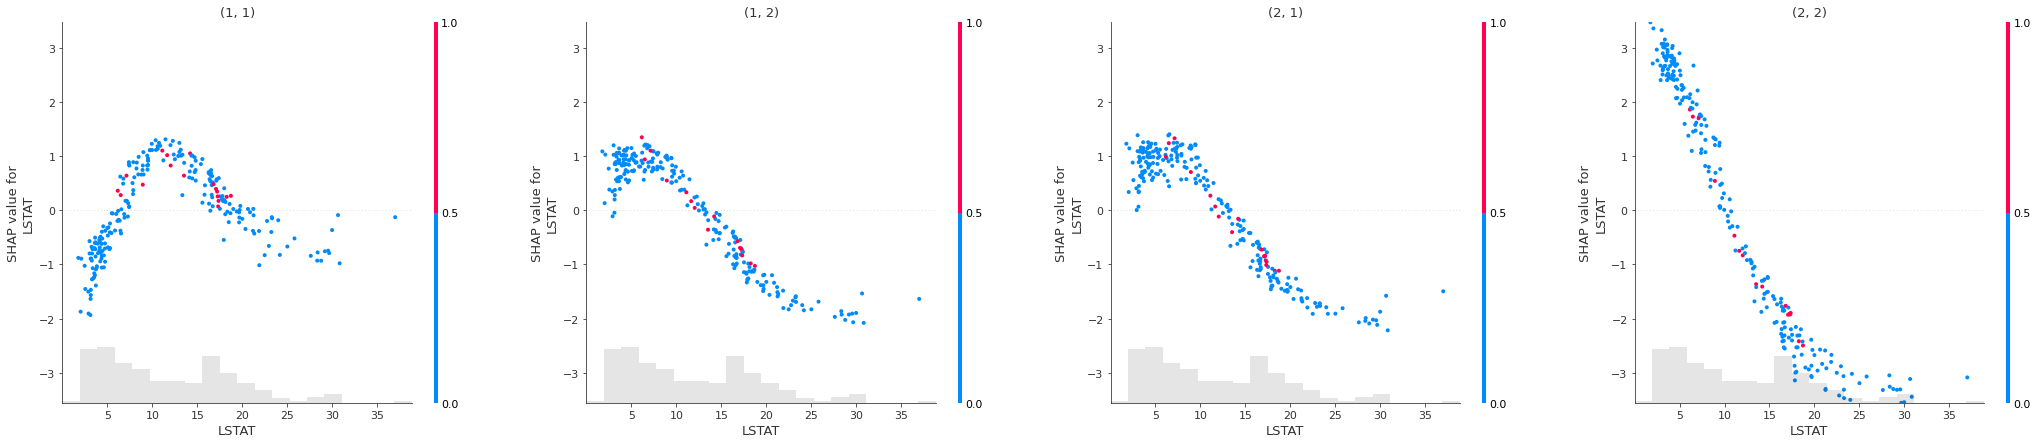

In [97]:
plot_next_feature()

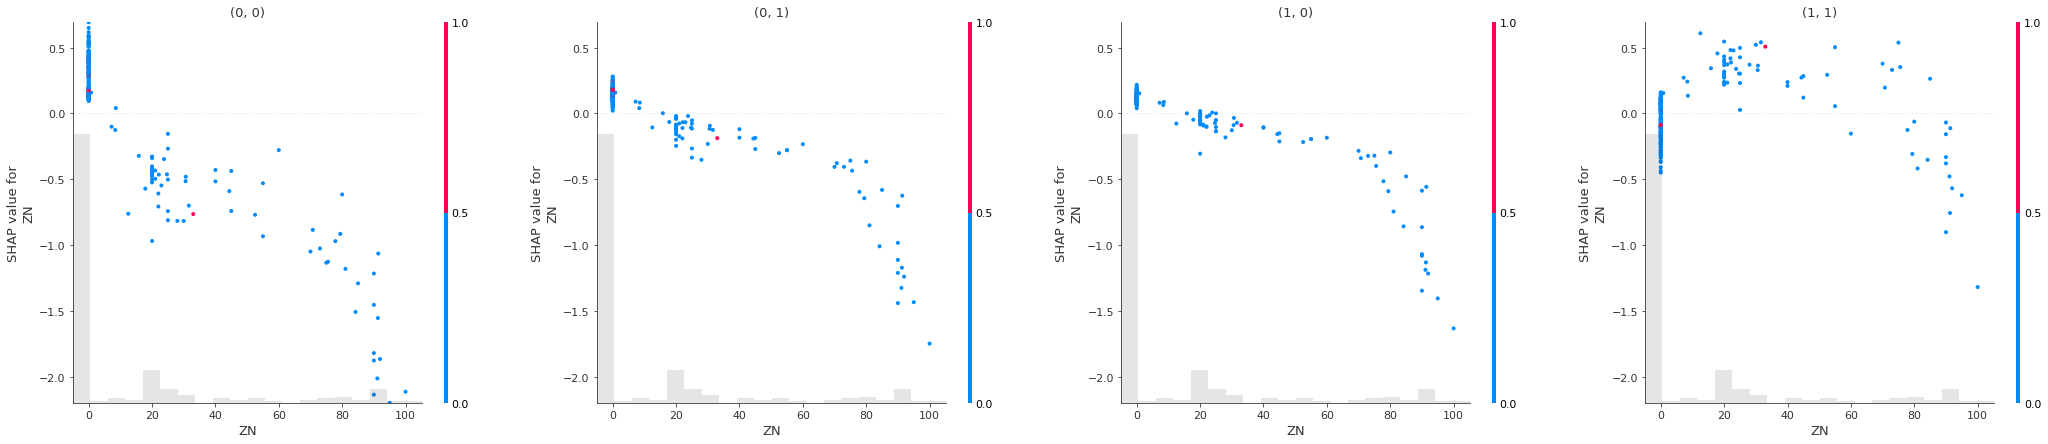

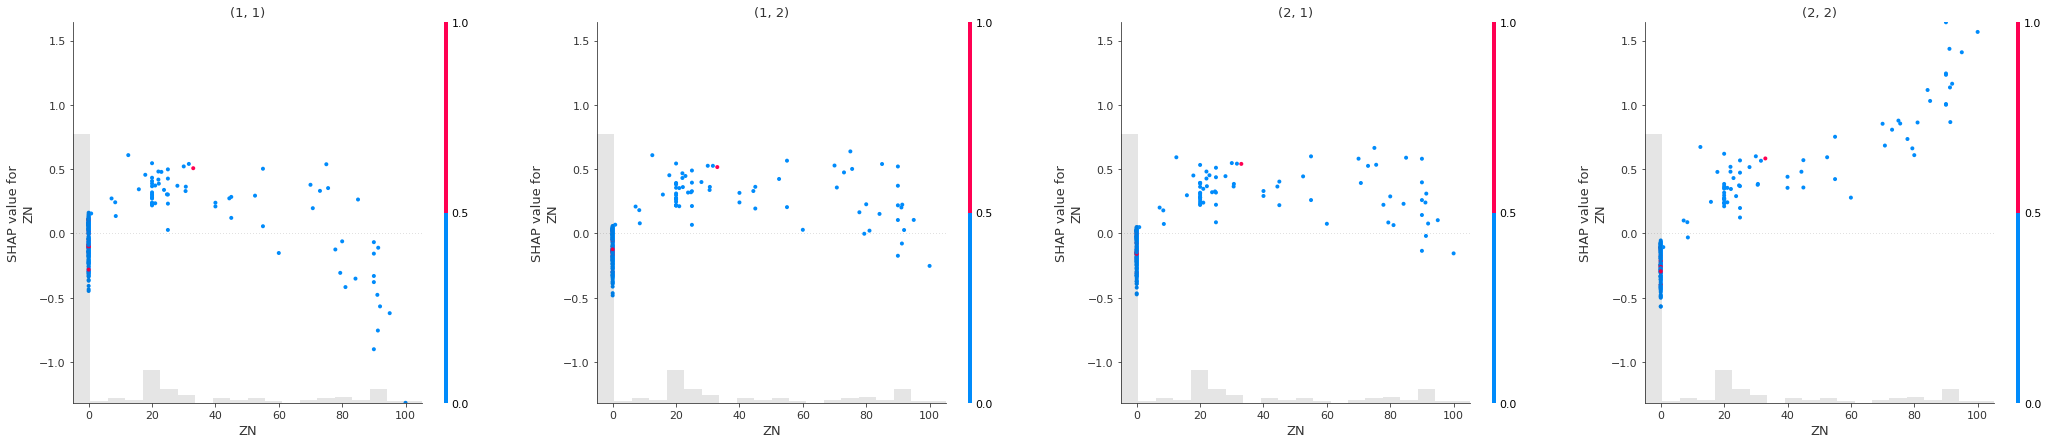

In [98]:
plot_next_feature()

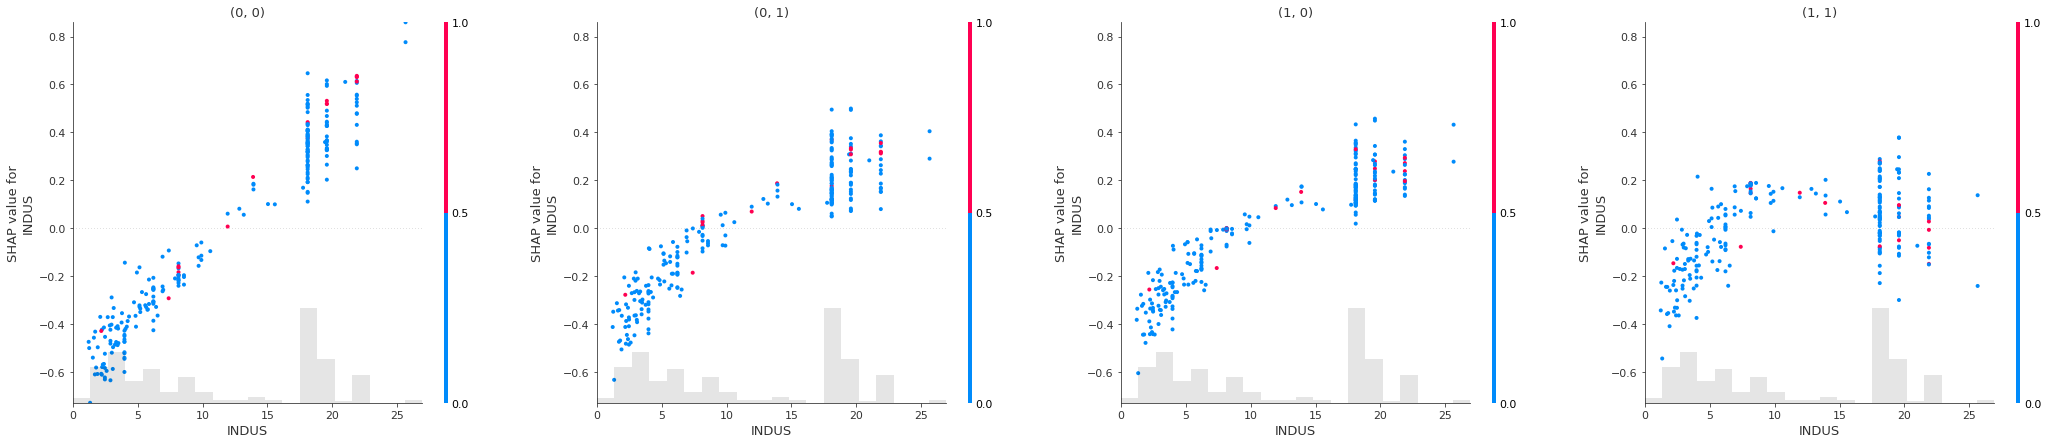

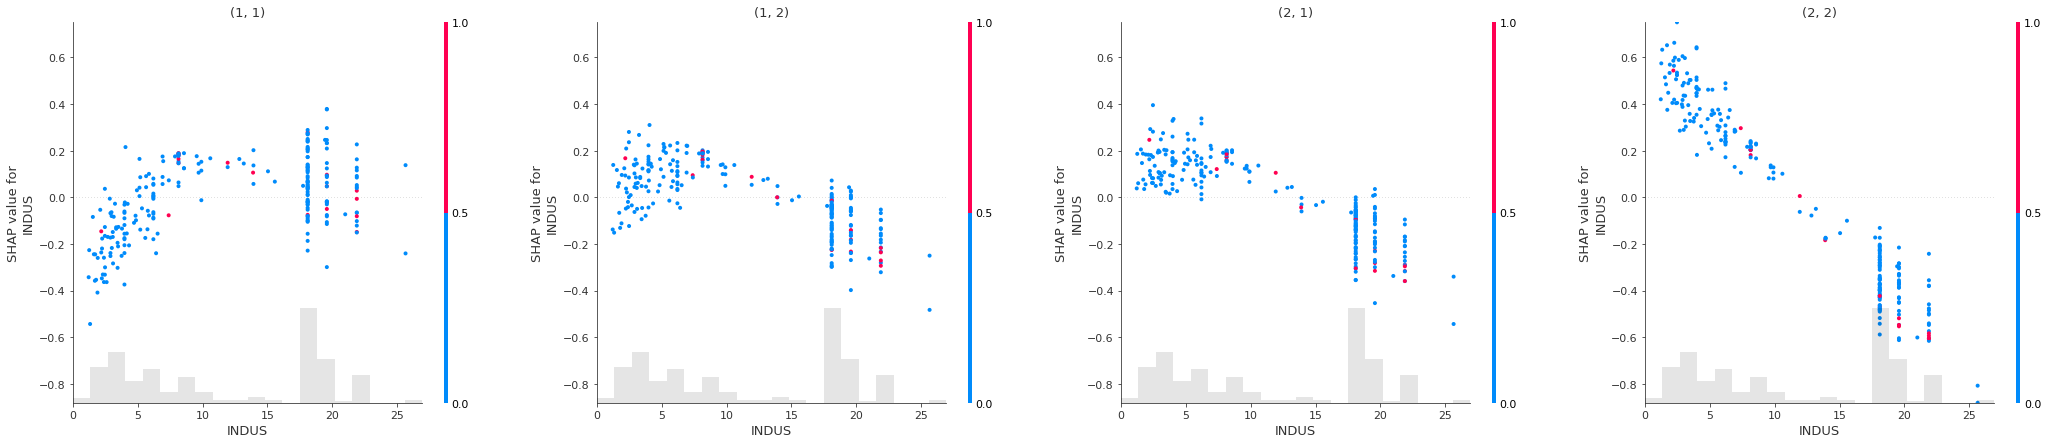

In [99]:
plot_next_feature()

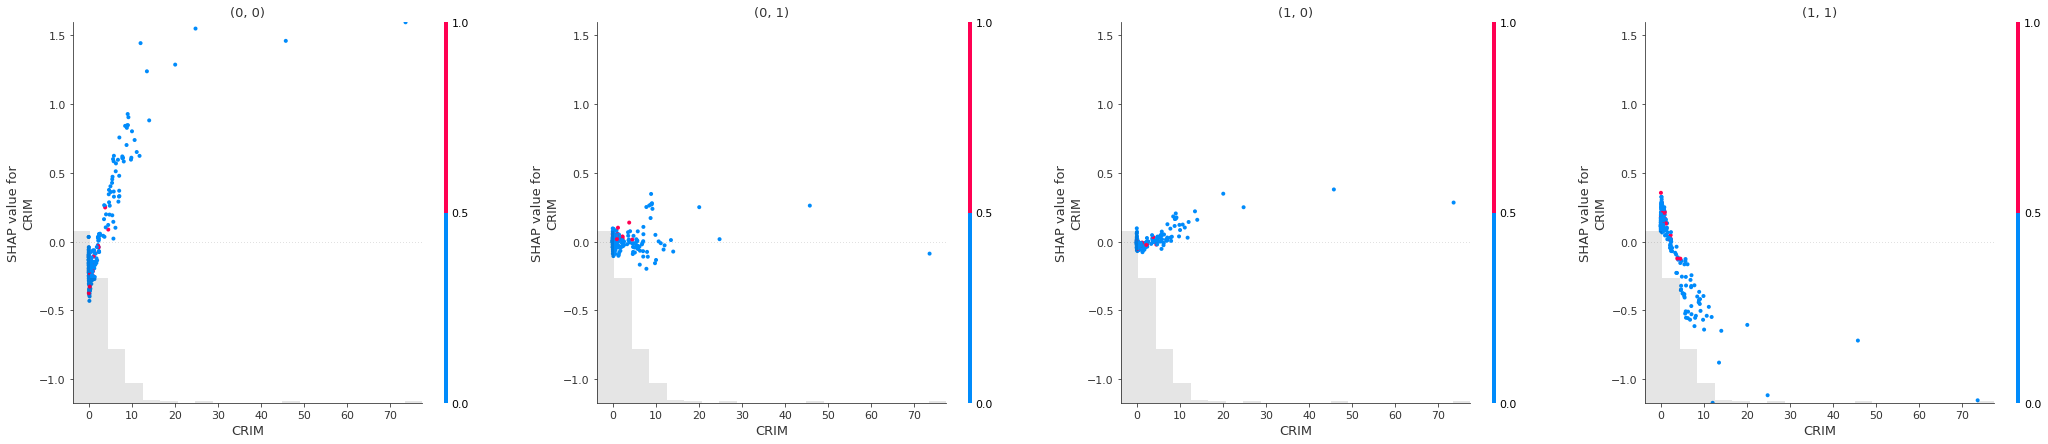

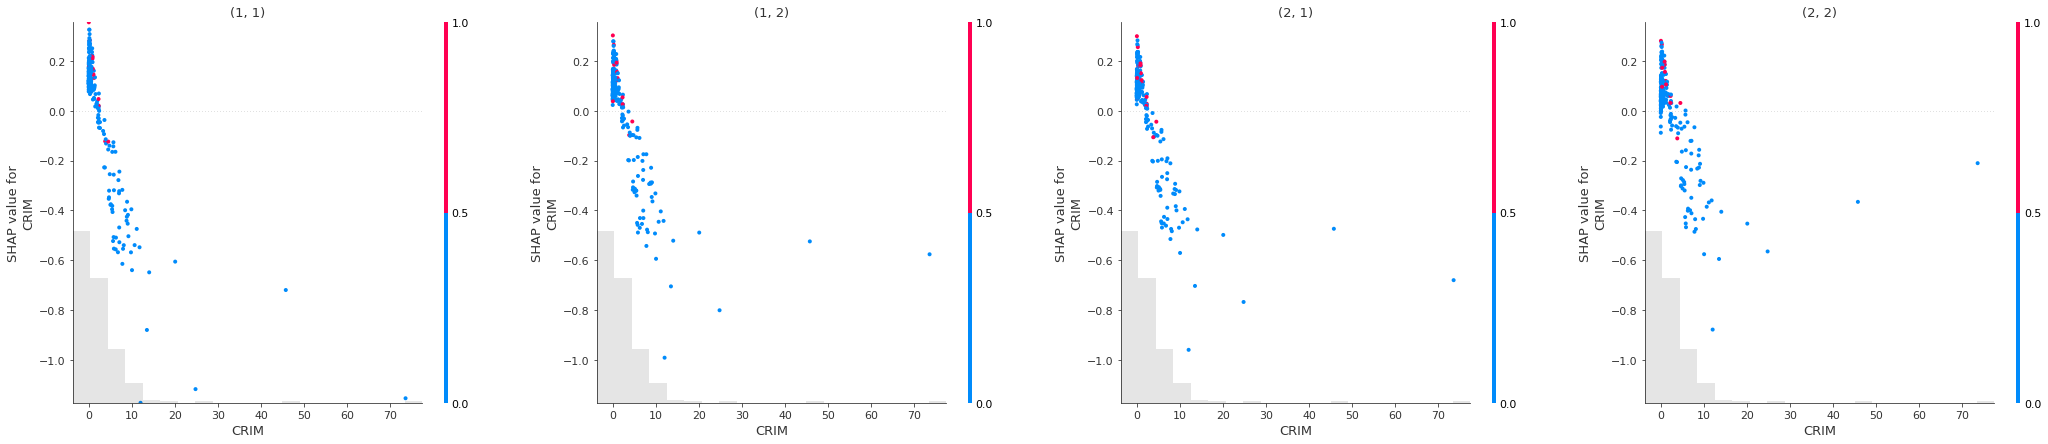

In [100]:
plot_next_feature()

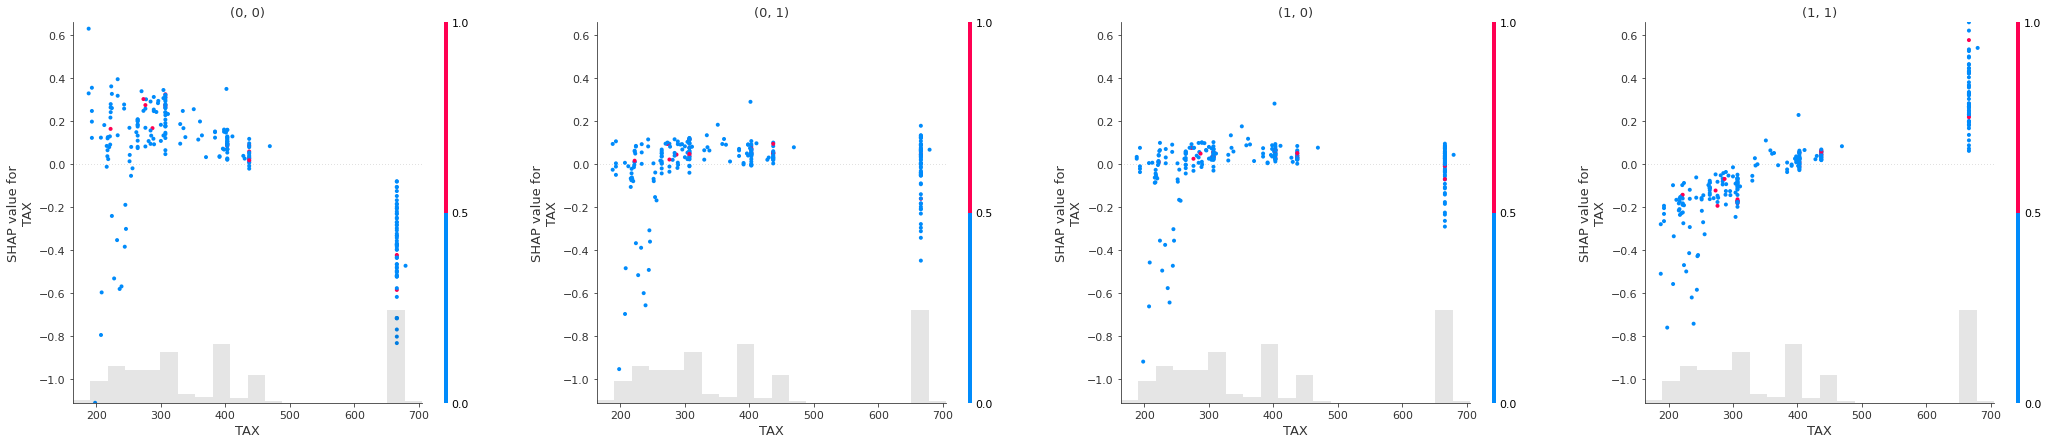

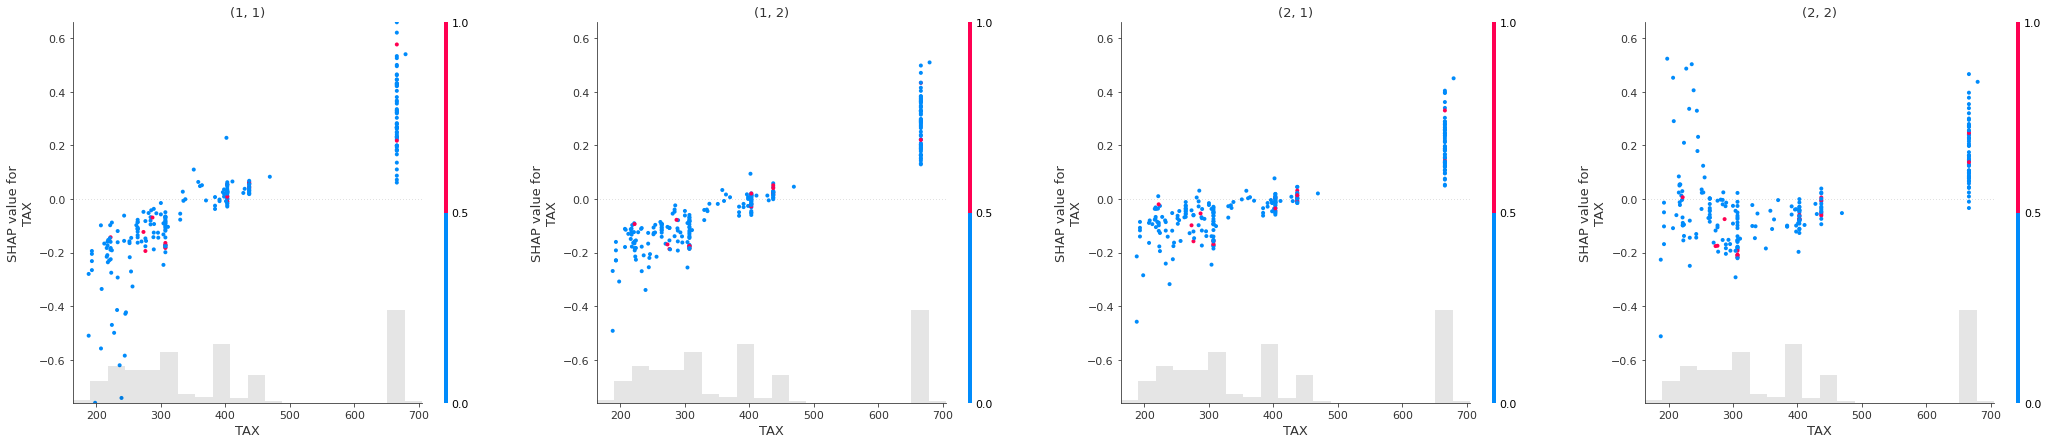

In [101]:
plot_next_feature()

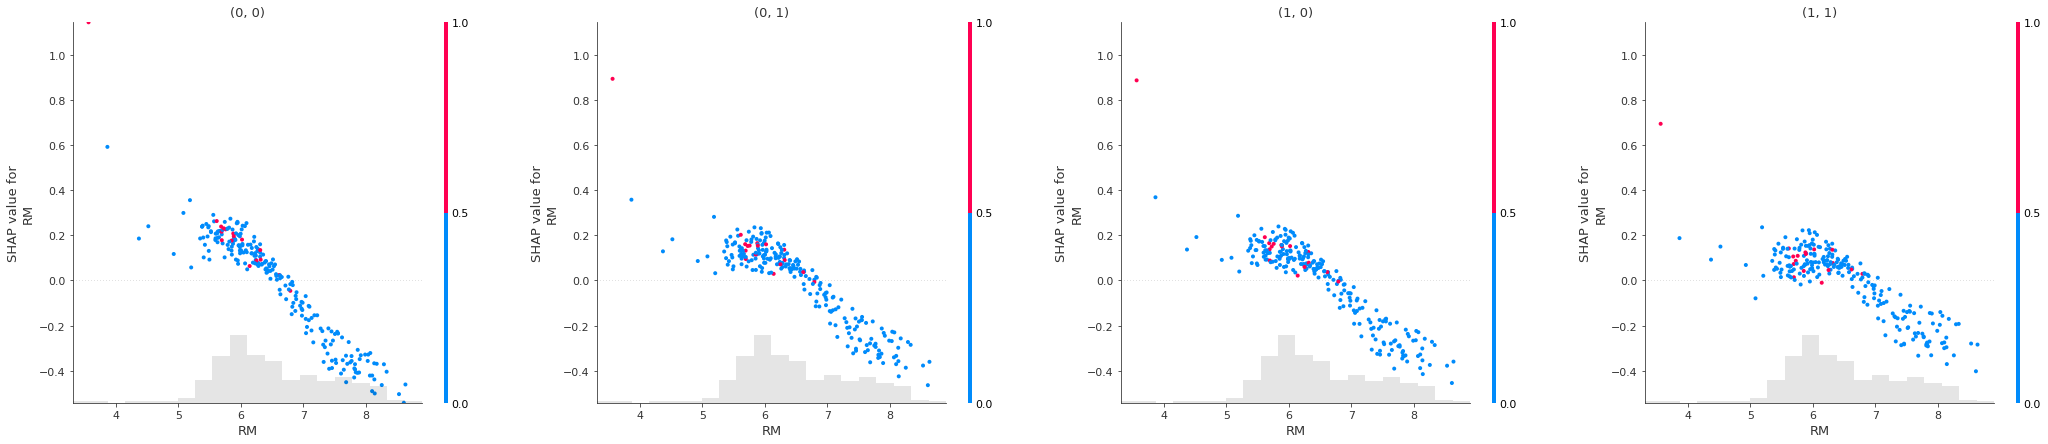

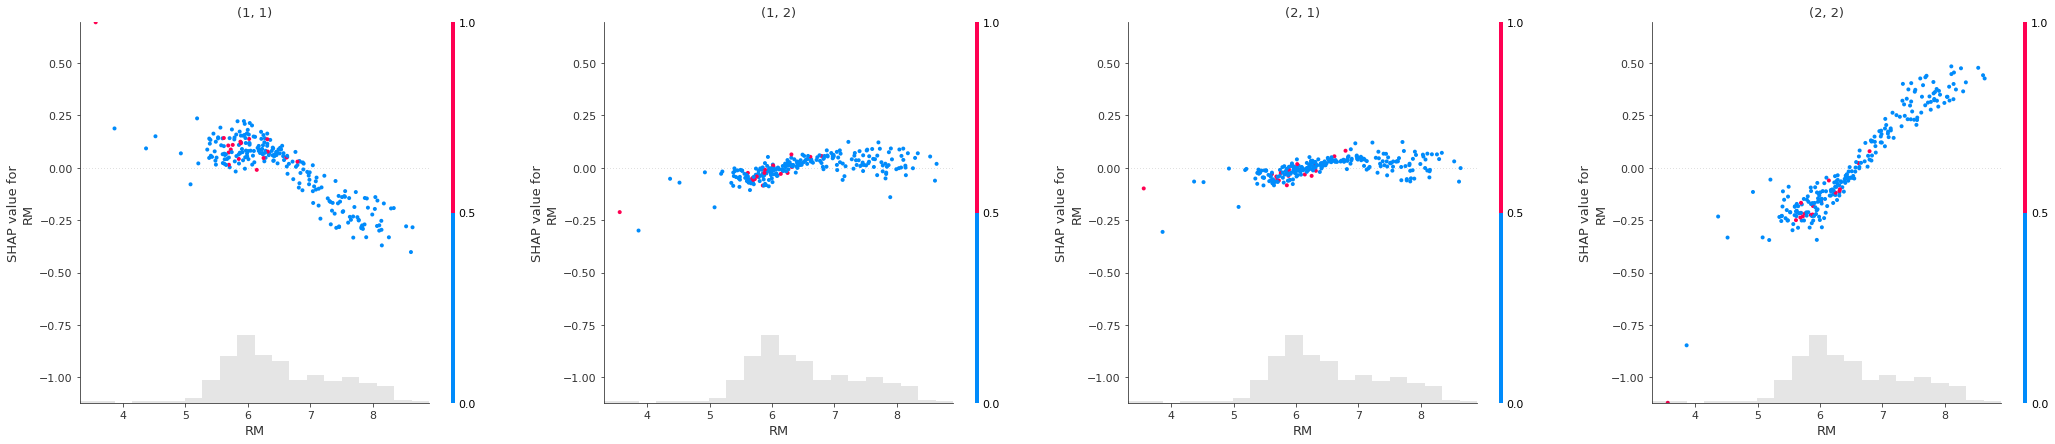

In [102]:
plot_next_feature()

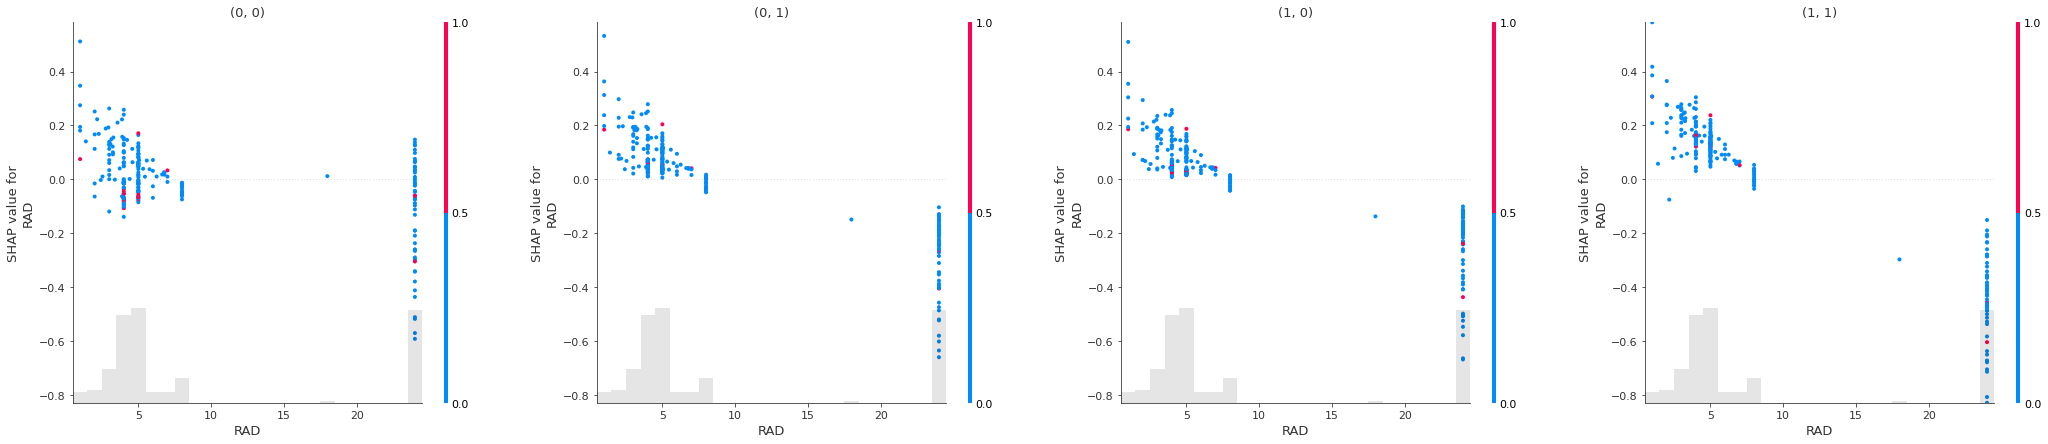

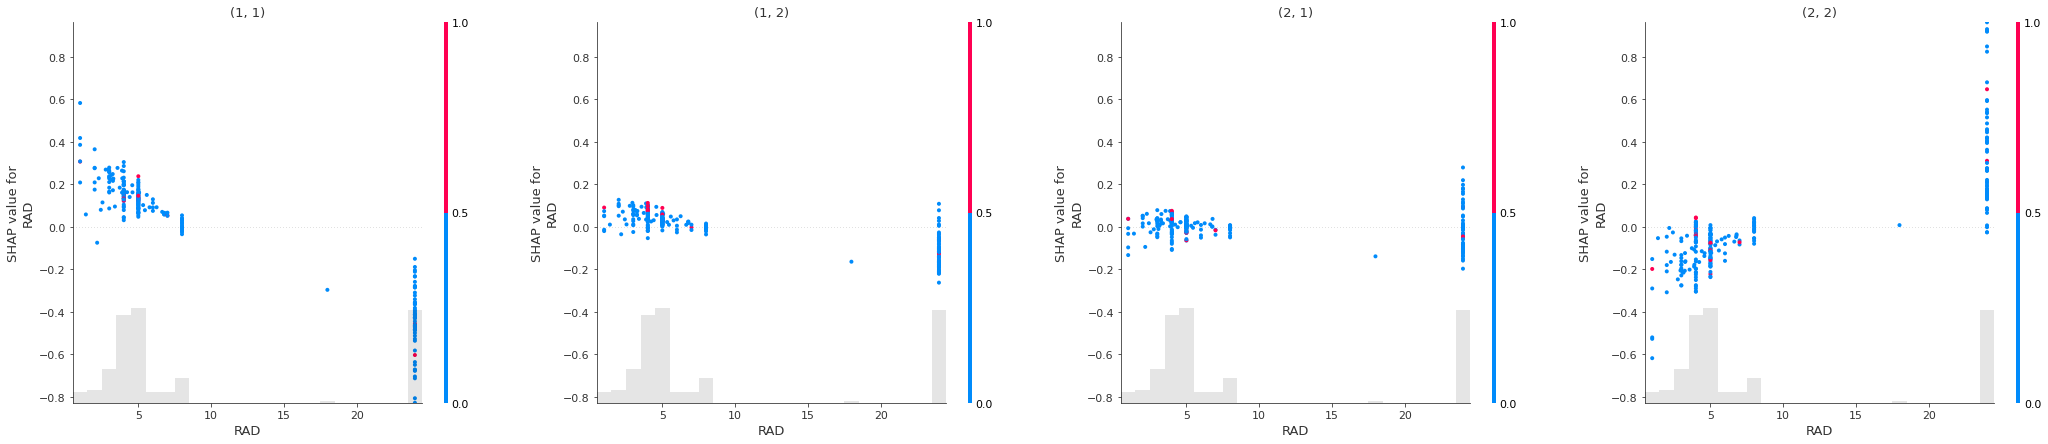

In [103]:
plot_next_feature()

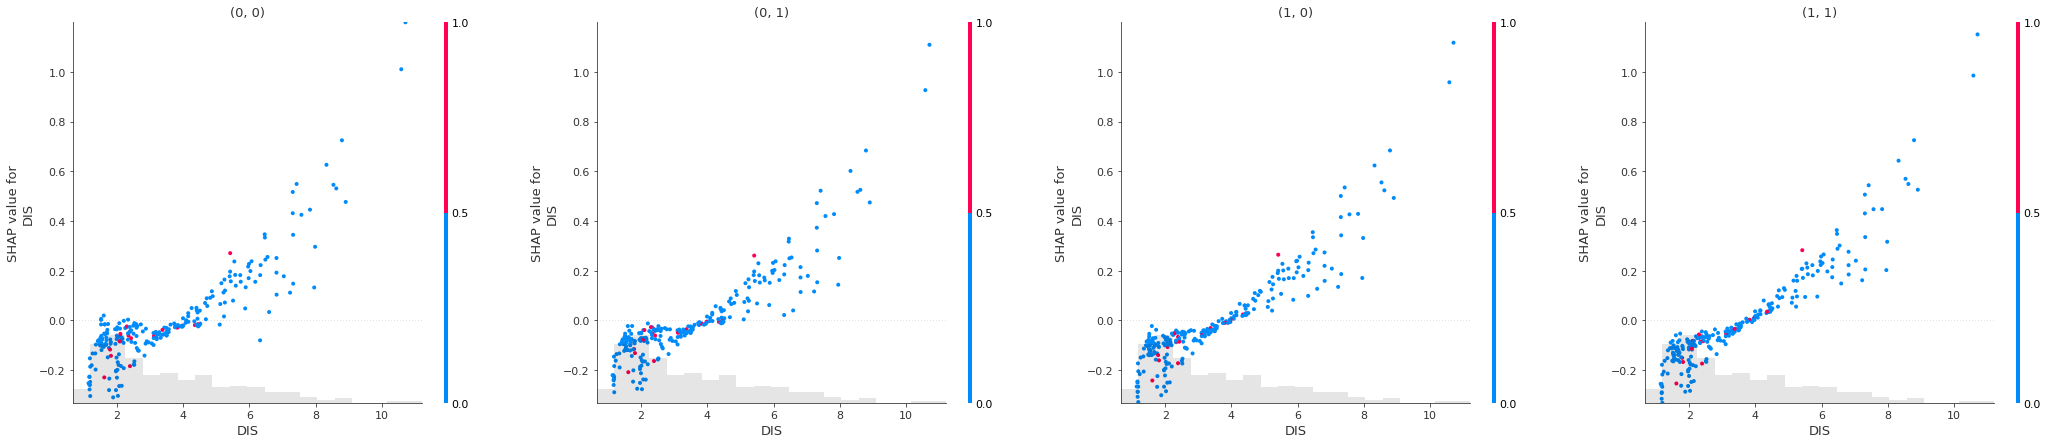

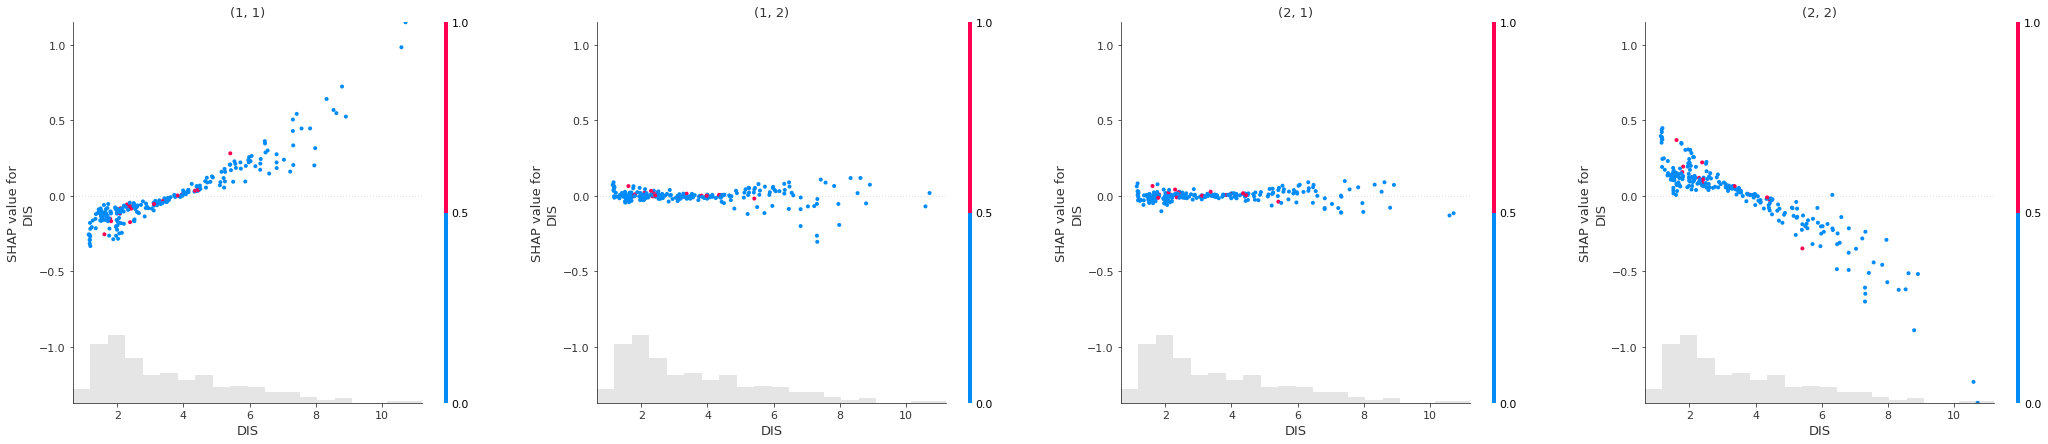

In [104]:
plot_next_feature()

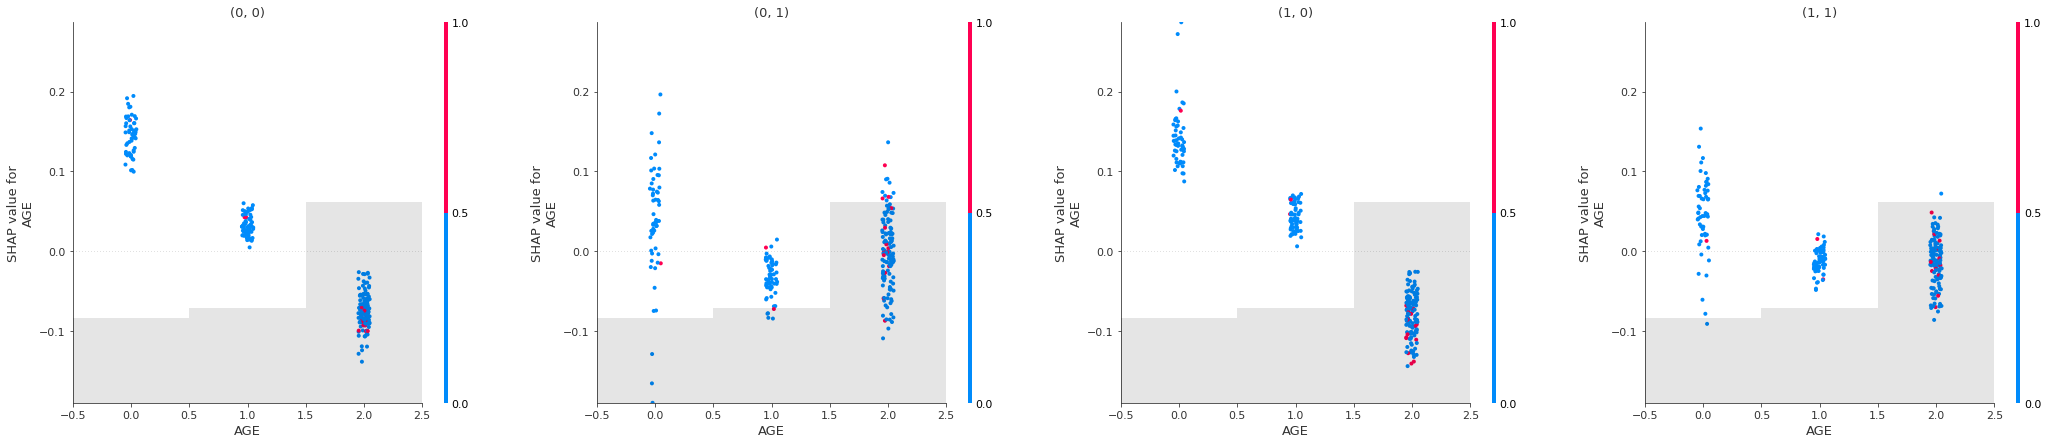

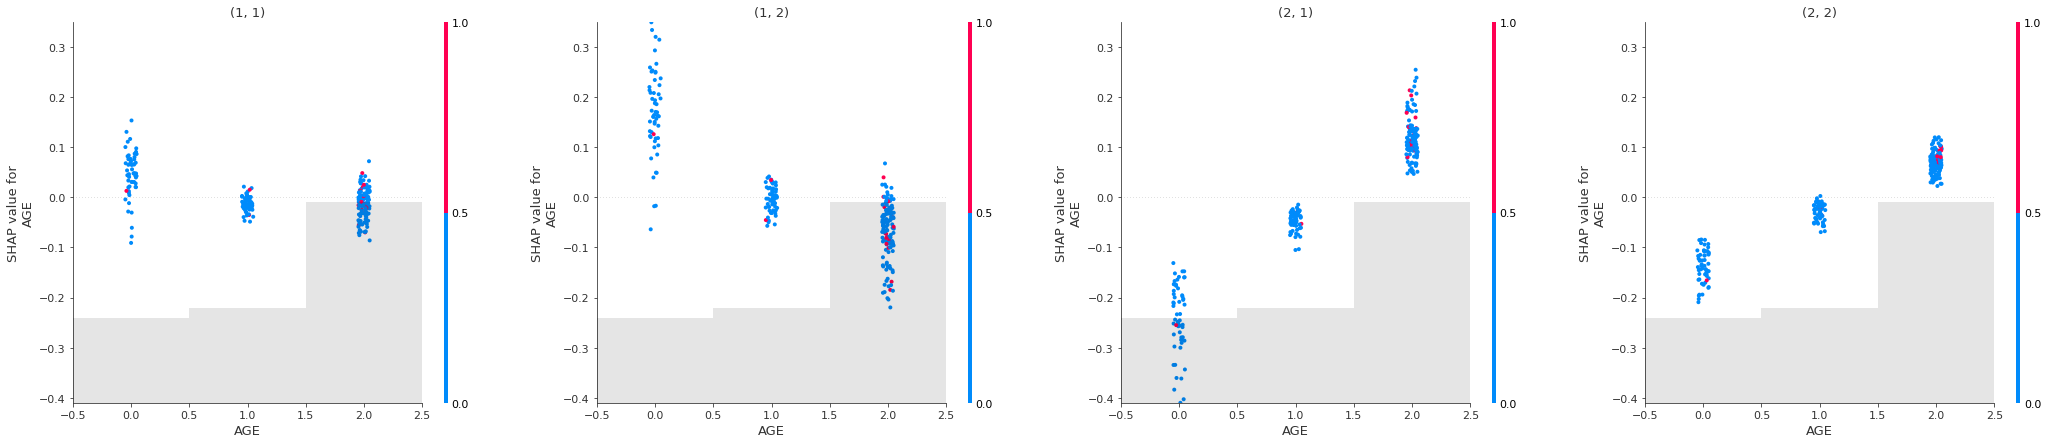

In [105]:
plot_next_feature()

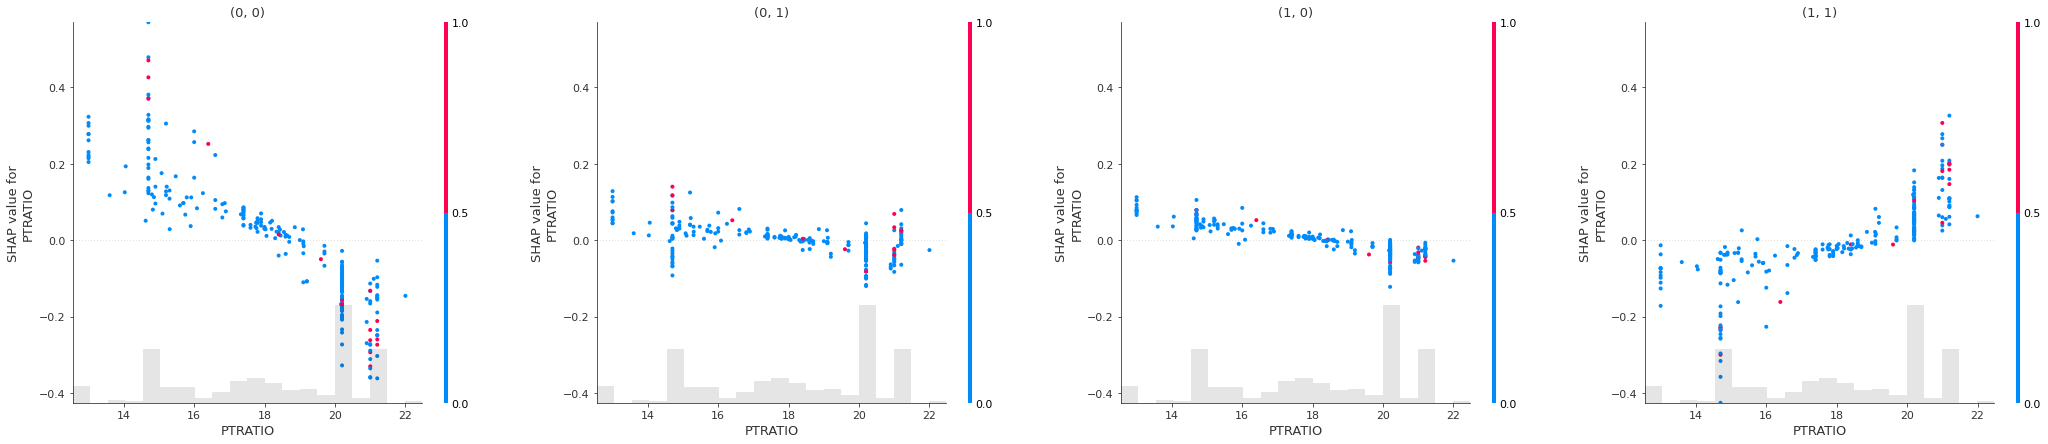

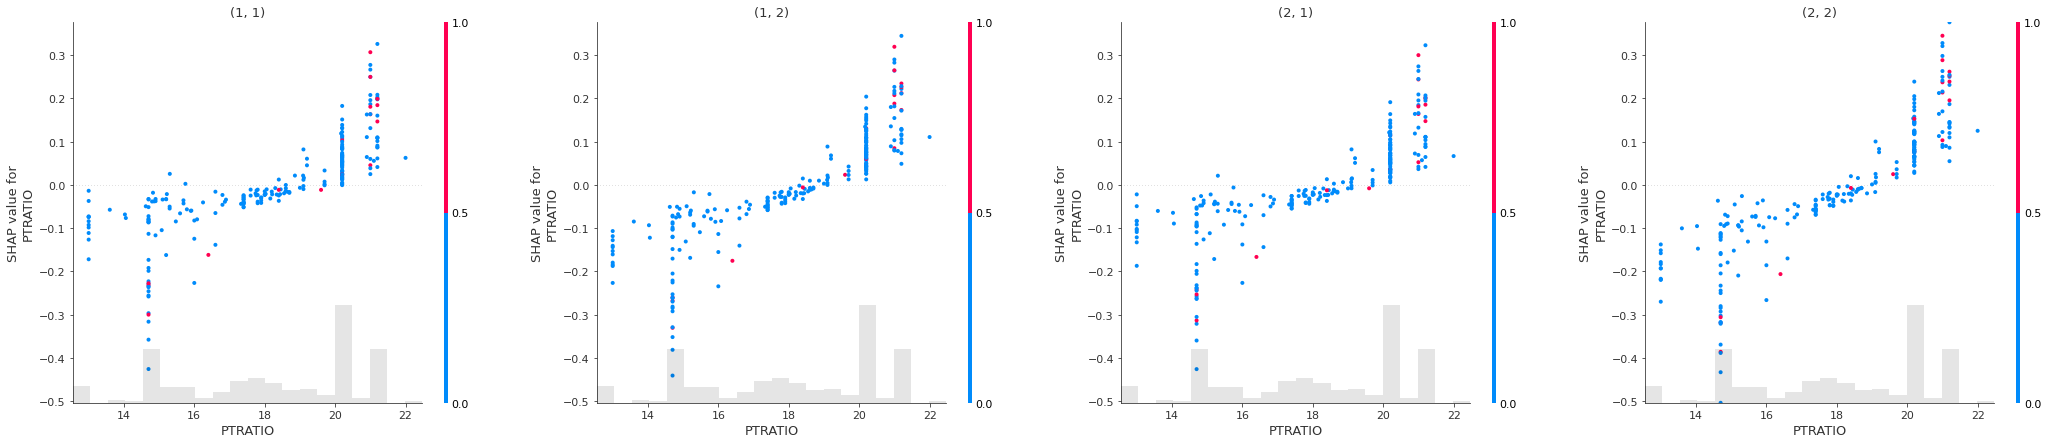

In [106]:
plot_next_feature()

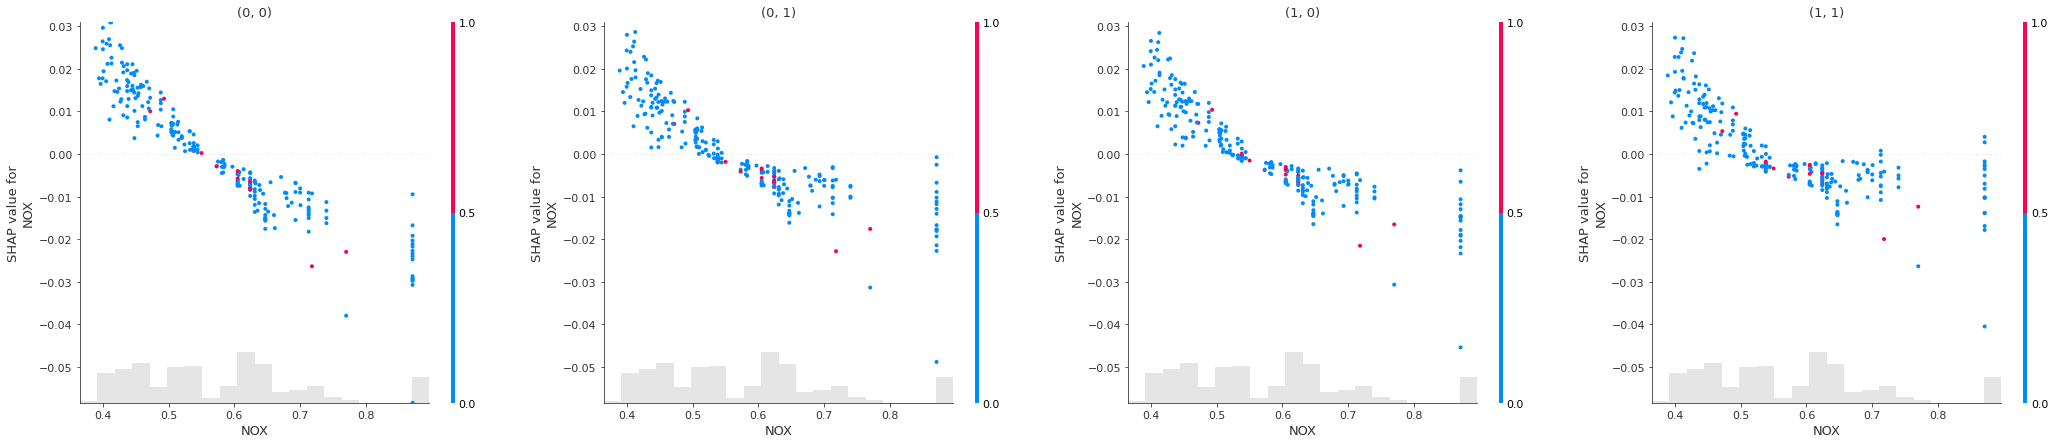

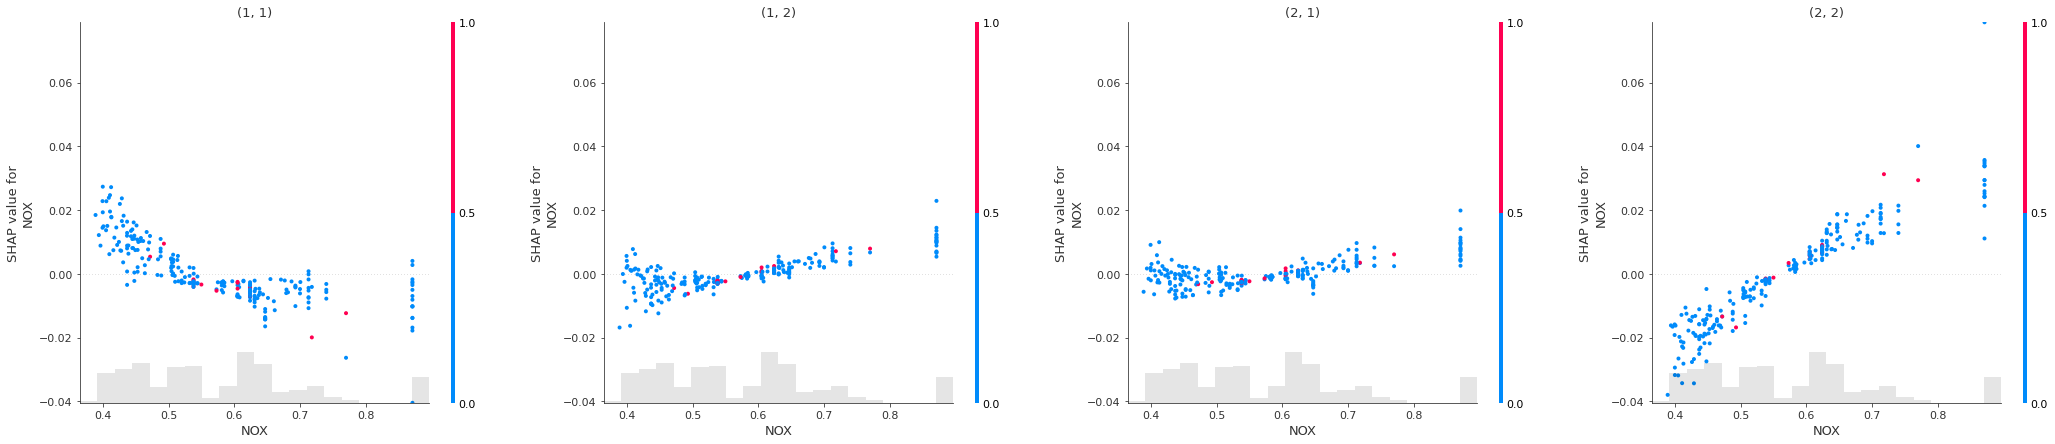

In [107]:
plot_next_feature()

# Local Explanations

In [4]:
pred_classes = comparer.class_names[mclass_diff]

## Clustering of Class $(0,1)$ SHAP Values

In [316]:
diff_class = '(0, 1)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

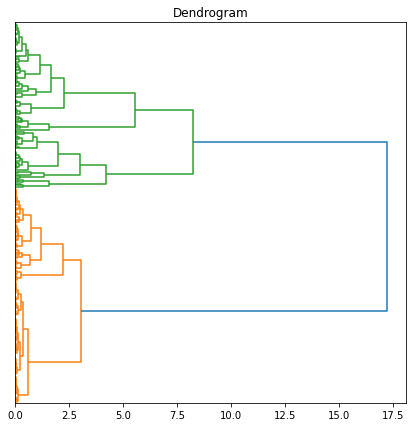

In [317]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [318]:
n_clusters = 6
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,52,13,0,0,14,0,0,0,0
c2,24,0,0,0,28,0,0,1,7
c4,0,0,0,0,10,1,0,2,18


In [319]:
def get_cluster(cluster):
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names

In [320]:
cluster, shap_values, pred_classes = get_cluster('c1')

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,52,13,0,0,14,0,0,0,0


### Global Effects

Instances in this cluster are characterized by:
- LSTAT ranges from 11 upwards
- ZN is just 0
- INDUS ranges from 4 upwards
- CRIM ranges up to 14
- RM ranges from 5 to 7
- RAD ranges from 2 upwards
- DIS ranges up to 6.3
- $AGE=0$ is underrepresented

That means:
- LSTAT has a high increasing effect on the outcome of class $(0,1)$ which decreases linearly below this range, while at around $LSTAT=10$ the increasing effect towards $(1,1)$ gets bigger than for $(0,1)$.
- ZN has a slight increasing effect on the outcome of class $(0,1)$. When increasing it, the effect decreases gradually and eventually becomes negative at around 10. At around 20, the increasing effect on $(1,1)$ reaches its maximum.

In [321]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,79.000000,79.0,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,17.237527,0.0,16.991110,3.667040,505.183883,6.018224,13.265672,2.508285,1.822785,19.205949,0.658687
std,3.091015,0.0,4.665134,3.414091,155.354884,0.368720,9.766049,0.993676,0.416318,2.385071,0.109681
min,11.100000,0.0,4.050000,0.045600,188.000000,5.080871,2.000000,1.358000,0.000000,14.700000,0.437000
25%,15.674013,0.0,18.100000,0.861035,403.000000,5.702430,4.000000,1.791150,2.000000,19.150000,0.583000
50%,16.796984,0.0,18.100000,2.332136,437.000000,5.985800,5.000000,2.247290,2.000000,20.200000,0.624000
75%,18.408803,0.0,19.580000,5.608159,666.000000,6.301260,24.000000,2.664810,2.000000,21.000000,0.713000
max,29.970000,0.0,25.650000,14.050700,679.526743,6.833000,24.000000,6.320000,2.000000,21.200000,0.871000


In [322]:
df['AGE'].value_counts()

2.0    66
1.0    12
0.0     1
Name: AGE, dtype: int64

In [331]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 10.2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",13.0,NaN
"(1, 1)",NaN,13.0


In [336]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",13.0,NaN
"(1, 1)",NaN,13.0


As shown, both features LSTAT and ZN have the power to change the predictions of all instances classified $(0,1)$ to $(1,1)$.
As a side-effect, those classified $(0,0)$ change as well to various other classes.

### Local Effects

Instances classified $(0,1)$ are characterized locally by:
- LSTAT ranges up to 18
- INDUS ranges from 8 to 22
- CRIM ranges up to 4
- TAX ranges from 276 upwards
- RM ranges from 5.6 to 6.3
- RAD ranges from 4 upwards
- DIS ranges up to 4.4
- $AGE=1$ is underrepresented

Explanations:
- With increasing values of LSTAT, the increasing effect on the outcome of $(0,1)$ is constant, but on $(0,0)$, it increases. This effect is strong enough to change all predictions of instances classified $(0,1)$ to $(0,0)$.
- With increasing values of CRIM, the increasing effect on the outcome of $(0,1)$ is constant, but on $(0,0)$, it increases. This effect is strong enough to change all predictions of instances classified $(0,1)$ to $(0,0)$.

In [337]:
df.iloc[pred_classes == diff_class, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,13.000000,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,15.570054,0.0,16.219231,1.316509,394.384615,5.886624,5.846154,2.840883,1.923077,19.192308,0.598692
std,2.686952,0.0,6.003980,1.073462,102.396727,0.230000,5.474884,0.974075,0.277350,2.865735,0.063987
min,11.100000,0.0,8.140000,0.045600,276.000000,5.614909,4.000000,1.788300,1.000000,14.700000,0.538000
25%,13.510000,0.0,8.140000,0.626837,307.000000,5.695859,4.000000,2.100000,2.000000,16.400000,0.538000
50%,17.066695,0.0,19.580000,0.976170,403.000000,5.854000,4.000000,2.388700,2.000000,21.000000,0.605000
75%,17.310000,0.0,21.890000,2.242360,437.000000,6.020228,5.000000,3.820836,2.000000,21.200000,0.624000
max,18.720000,0.0,21.890000,3.836840,666.000000,6.319000,24.000000,4.441690,2.000000,21.200000,0.770000


In [338]:
df['AGE'].iloc[pred_classes == diff_class].value_counts()

2.0    12
1.0     1
Name: AGE, dtype: int64

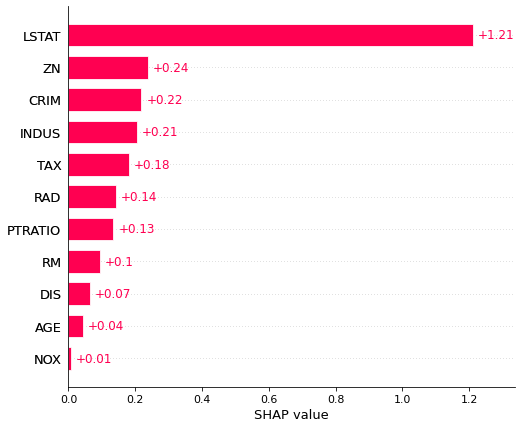

In [339]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 1)']])
plot_feature_importance_bar(feature_importances)

In [343]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

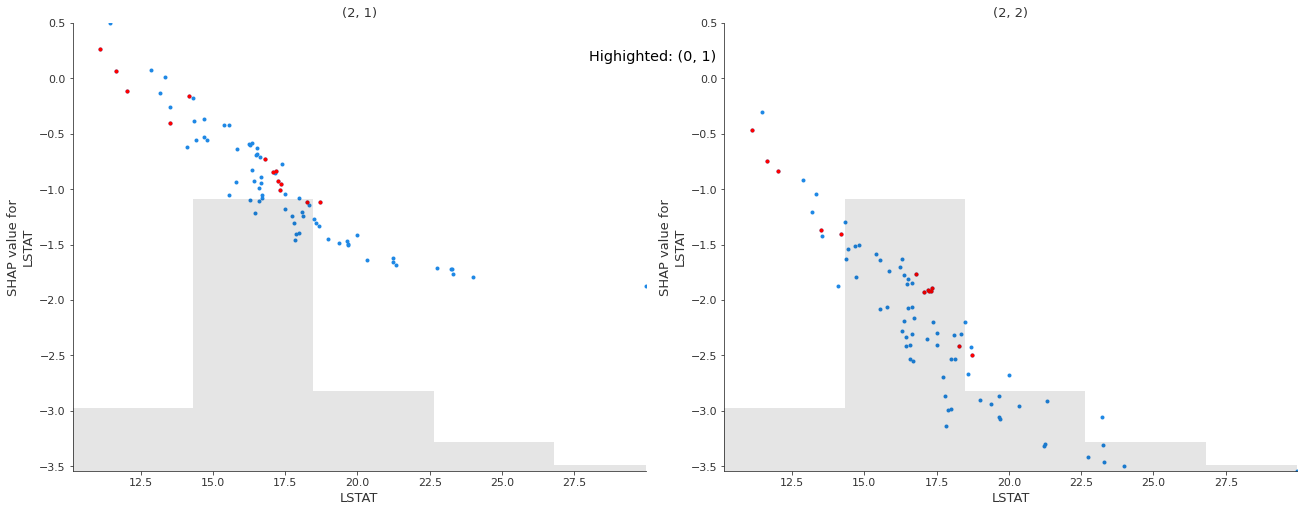

In [344]:
plot_feature('LSTAT')

In [351]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 19.2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,13.0
"(0, 1)",13.0,NaN


Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


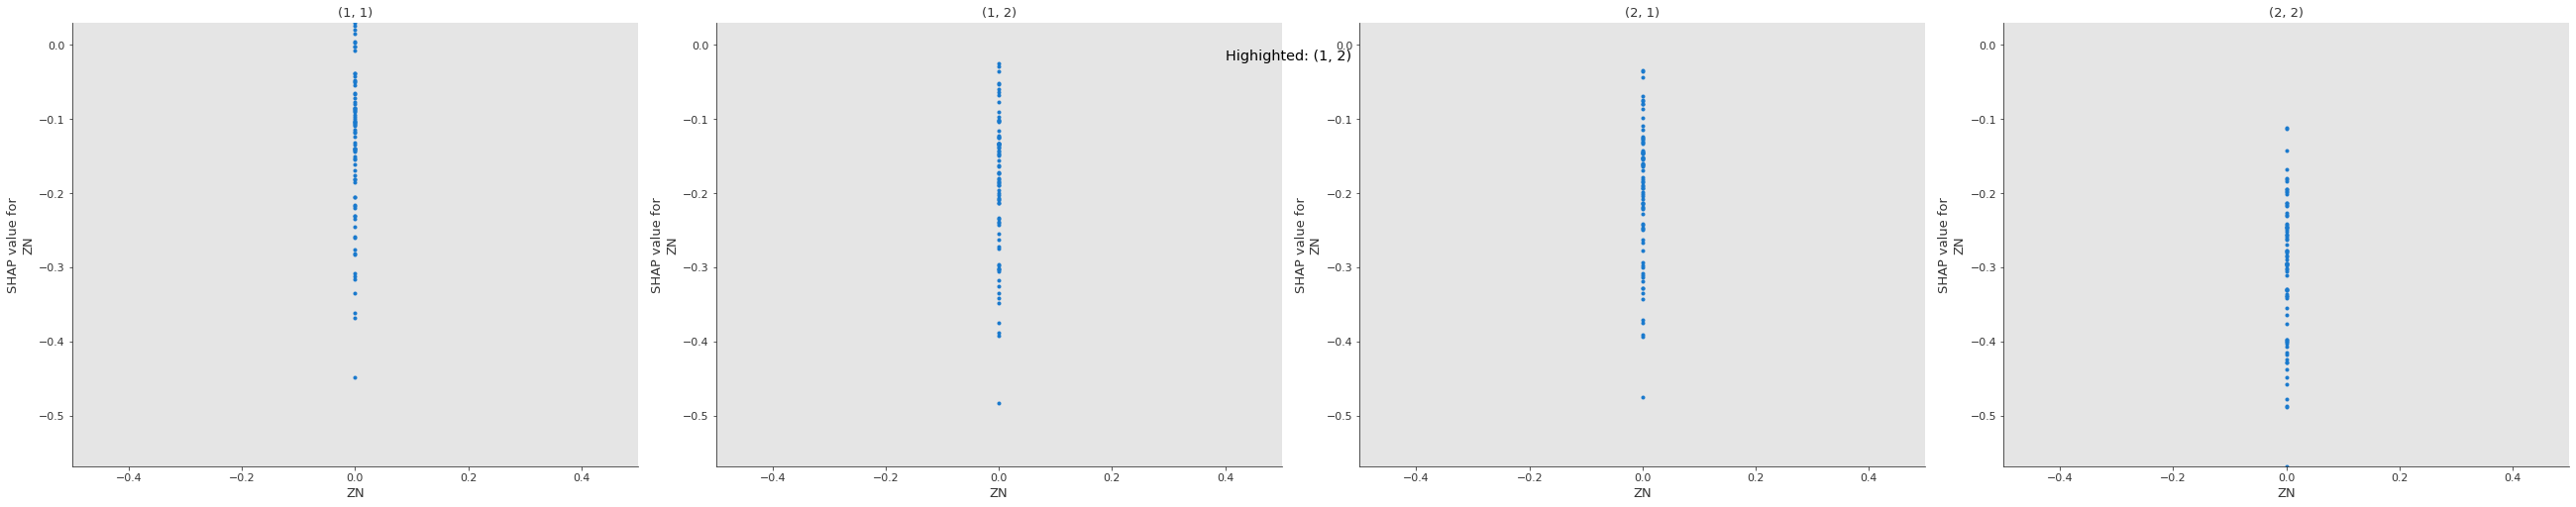

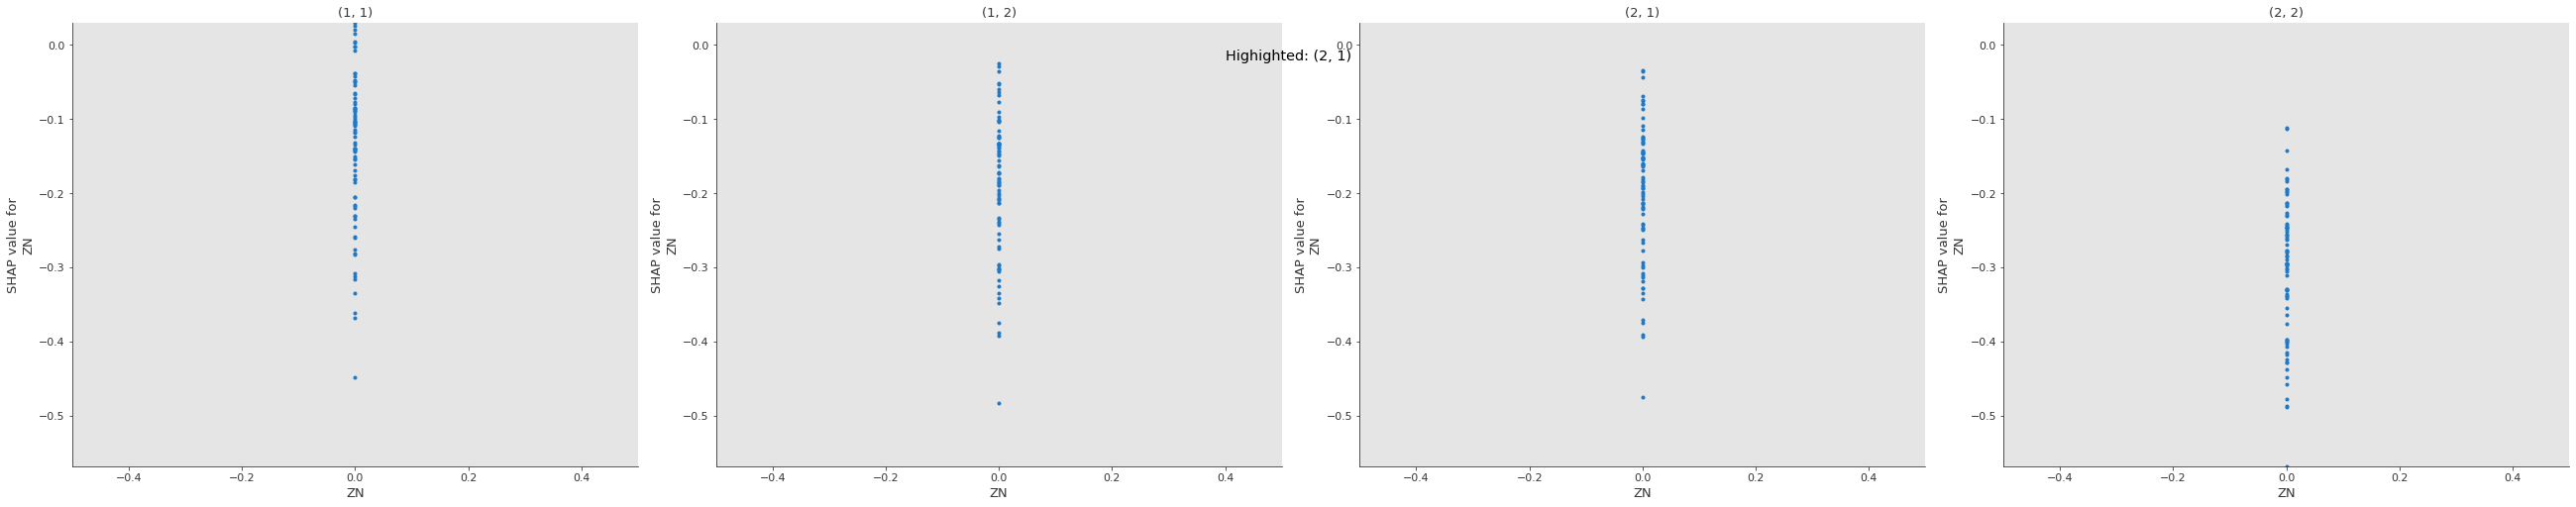

In [137]:
plot_feature('ZN')

In [78]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 4.05
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",13.0,2
"(1, 1)",NaN,11


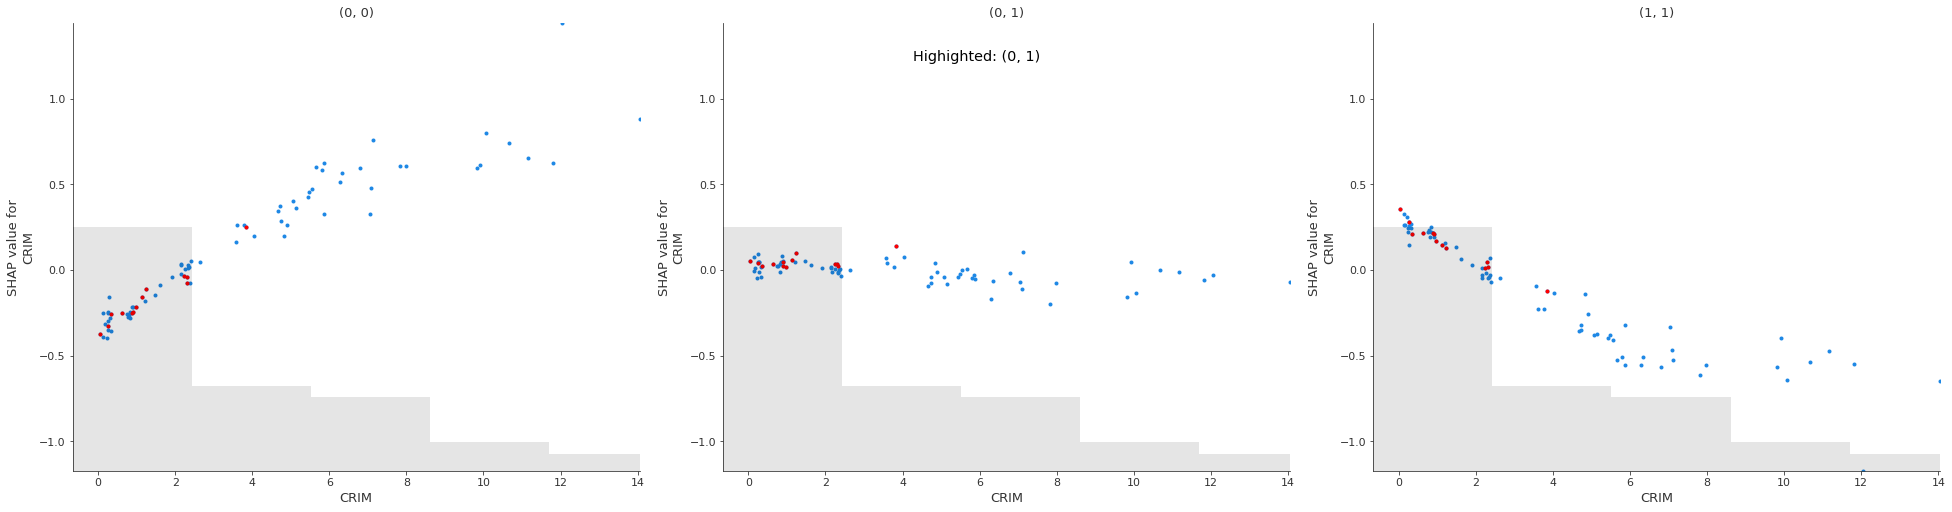

In [79]:
plot_feature('CRIM')

In [359]:
X_test_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test_test)])
X_test_test['CRIM'] = 6.2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,13.0
"(0, 1)",13.0,NaN


## Clustering of Class $(1,2)$ SHAP Values

In [4]:
diff_class = '(1, 2)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

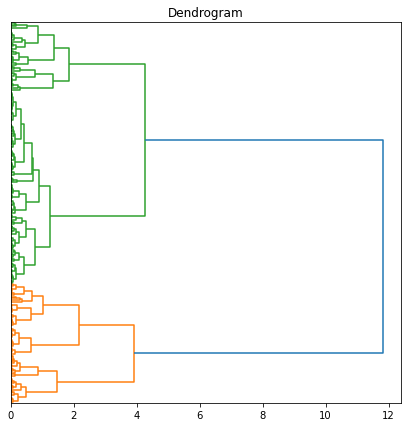

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

Class $(1,2)$ is the only difference class in a cluster from $n=18$ upwards, but just with 3 instances classified $(1,1)$, which is a very small cluster size. Instead, I will start with $n=3$.

In [6]:
n_clusters = 3
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,71,6,0,0,0,0,0,0,0
c2,0,0,0,0,30,1,0,3,91
c3,5,7,0,0,28,0,0,0,4


In [7]:
def get_cluster(cluster):
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names

In [8]:
cluster, shap_values, pred_classes = get_cluster('c2')
classes = ['(1, 2)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c2,0,0,0,0,30,1,0,3,91


### Global Effects

Instances in this cluster are characterized by:
- LSTAT ranges up to 11.45
- INDUS ranges up to 19.58
- CRIM ranges up to 9.23

That means:
- LSTAT has a high increasing effect on the outcome of class $(1,2)$ which decreases above this range, while at around $LSTAT=12$ the increasing effect towards $(1,1)$ gets bigger than for $(1,2)$.
- INDUS has a decreasing effect on $(1,2)$ with increasing feature values above 19.58 and a constant effect on $(1,1)$

In [12]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,5.860039,20.821915,7.809052,1.382590,348.809617,7.073057,7.790701,4.103973,0.928000,17.261713,0.516357
std,2.356405,29.418265,6.314216,2.556333,151.000013,0.788781,7.304168,2.189019,0.804984,2.362061,0.093658
min,1.763949,0.000000,1.210000,0.009060,193.000000,3.561000,1.000000,1.137912,0.000000,13.000000,0.389000
25%,3.825654,0.000000,3.069088,0.055168,245.852204,6.490000,4.000000,2.200118,0.000000,15.220323,0.442900
50%,5.269507,0.000000,5.190000,0.212100,300.000000,7.088000,5.000000,3.558008,1.000000,17.400000,0.504000
75%,7.440000,25.007650,12.830000,0.629760,401.014836,7.688243,8.000000,5.541920,2.000000,19.090431,0.605000
max,11.450000,100.000000,19.580000,9.232300,666.000000,8.638029,24.000000,10.710300,2.000000,22.000000,0.871000


In [13]:
df['AGE'].value_counts()

0.0    45
1.0    44
2.0    36
Name: AGE, dtype: int64

In [14]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 11.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1.0
"(1, 2)",1.0,NaN


In [21]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 19.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1.0
"(1, 2)",1.0,NaN


### Local Effects

Explanations:
- With decreasing values of LSTAT, the increasing effect on the outcome of $(1,2)$ is constant, but on $(2,2)$, it increases. This effect is strong enough to change the prediction of the instance classified $(1,2)$ to $(2,2)$.
- With increasing values of ZN, the increasing effect on the outcome of $(1,2)$ increases until approx. 30 and stays at this level or decreases for even higher values, but on $(2,2)$, it further increases. This effect is strong enough to change the prediction of the instance classified $(1,2)$ to $(2,2)$.

In [375]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
23,6.15,0.0,7.38,0.30347,287.0,6.312,5.0,5.4159,0.0,19.6,0.493


In [376]:
df['AGE'].iloc[pred_classes == diff_class].value_counts()

0.0    1
Name: AGE, dtype: int64

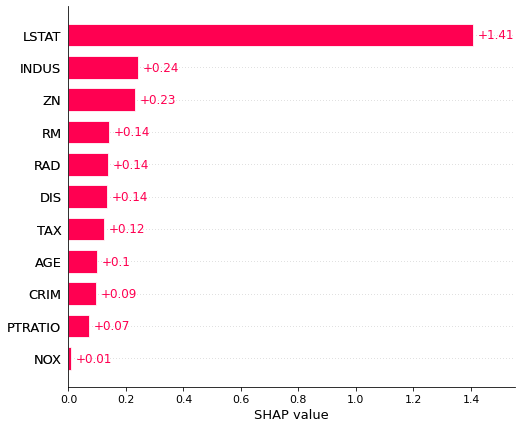

In [377]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

In [378]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

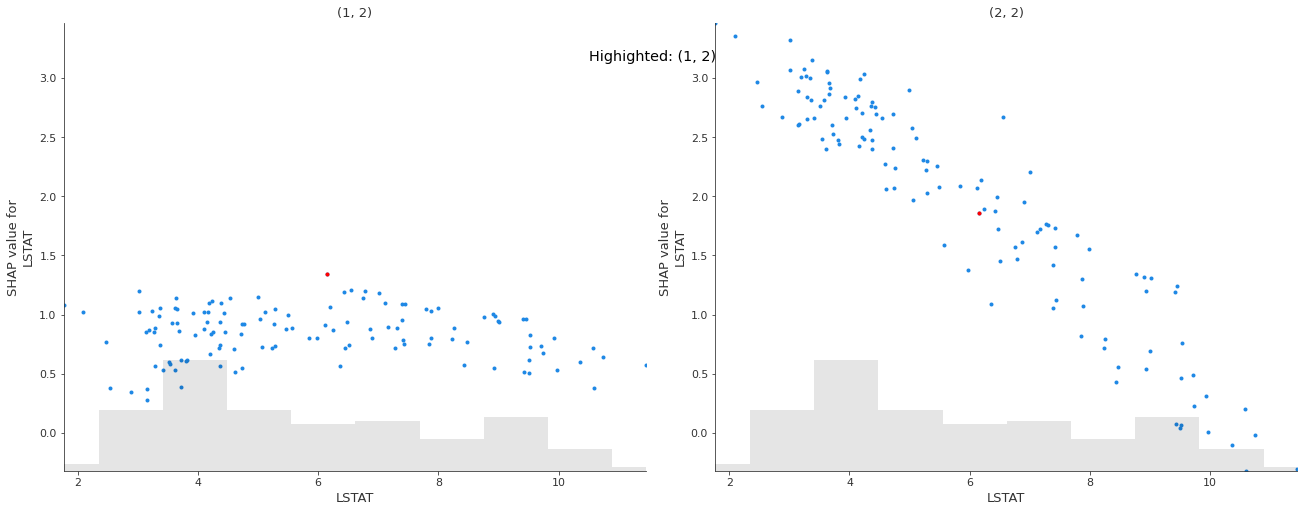

In [379]:
plot_feature('LSTAT')

In [386]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 4.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 2)",1.0,NaN
"(2, 2)",NaN,1.0


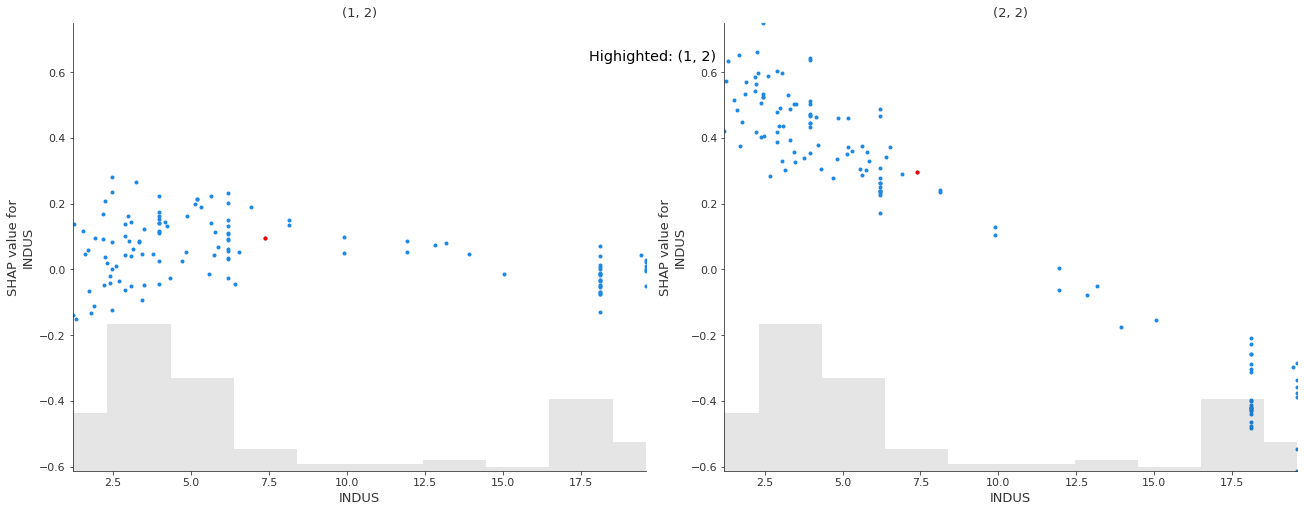

In [168]:
plot_feature('INDUS')

In [170]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 1.21
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 2)",1,1


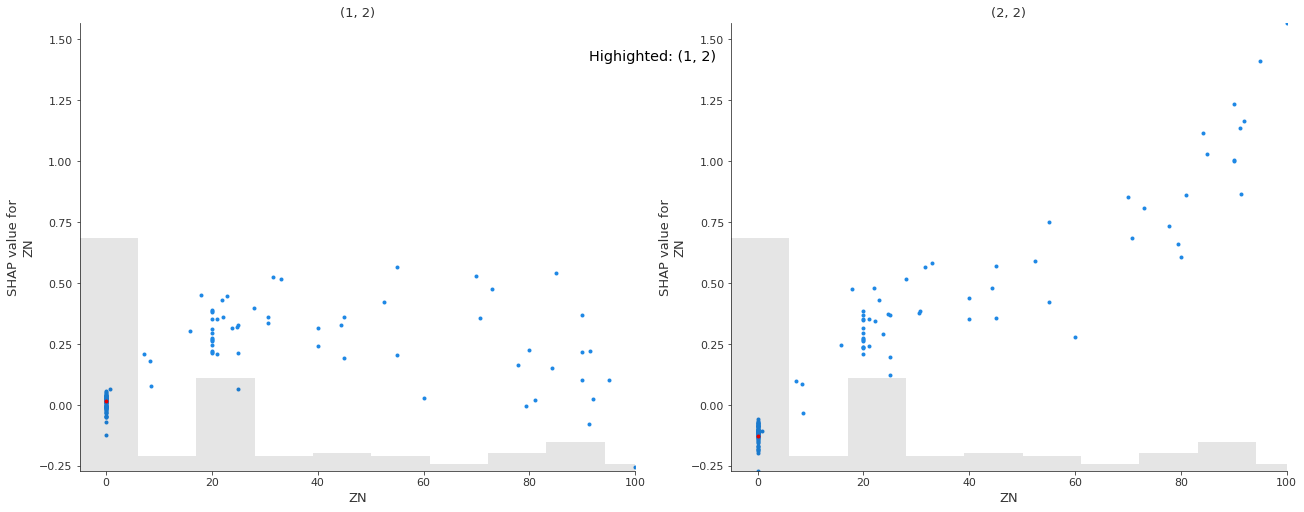

In [171]:
plot_feature('ZN')

In [387]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 90
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 2)",1.0,NaN
"(2, 2)",NaN,1.0


## Clustering of Class $(2,1)$ SHAP Values

In [173]:
diff_class = '(2, 1)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

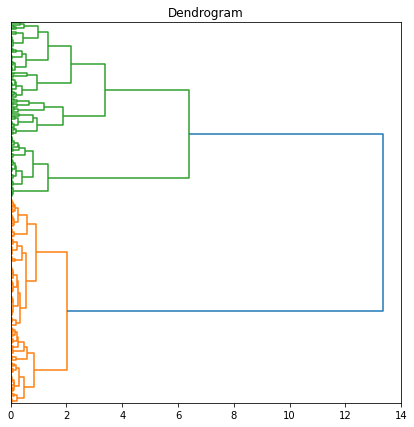

In [174]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

At $n=14$, the clustering yields two clusters where this class occurs without any other difference classes.

In [188]:
n_clusters = 14
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,0,0,0,0,23,0,0,1,25
c2,0,0,0,0,11,1,0,0,46
c3,0,0,0,0,2,0,0,2,22
c8,1,3,0,0,0,0,0,0,0
c9,2,1,0,0,3,0,0,0,0
c12,12,4,0,0,0,0,0,0,0
c13,1,4,0,0,6,0,0,0,0
c14,3,1,0,0,1,0,0,0,0


In [189]:
def get_cluster(cluster):
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names

### Cluster c1

In [190]:
cluster, shap_values, pred_classes = get_cluster('c1')
classes = ['(1, 1)', '(2, 1)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,0,0,0,0,23,0,0,1,25


#### Global Effects

Instances in this cluster are characterized by:
- LSTAT ranges up to 13
- INDUS ranges up to 18
- CRIM ranges up to 5.8
- RM reaches from 5.7 upwards
- $AGE=2$ is underrepresented, $AGE=0$ is overrepresented

That means:
- LSTAT has a high increasing effect on the outcome of class $(2,1)$ which decreases above this range, while the increasing effect on $(1,1)$ is at its maximum at the border.
- When increasing INDUS further, its effect on $(2,1)$ decreases into the negative but stays constantly somewhere between -0.1 and +0.3 for $(1,1)$.

In [191]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,6.787841,43.269790,5.395214,0.378155,313.195032,6.892385,5.429497,5.600280,0.326531,17.282097,0.455786
std,3.313969,34.769825,4.551051,1.161411,111.496217,0.722738,5.061412,1.923803,0.515904,2.217552,0.059250
min,2.022086,0.000000,1.210000,0.009060,198.000000,5.707000,1.000000,2.115348,0.000000,13.000000,0.389000
25%,3.716021,20.000000,2.387516,0.032912,236.050687,6.249000,3.569430,4.148635,0.000000,15.300000,0.413000
50%,5.980000,33.000000,3.478945,0.054970,285.000000,6.986011,4.000000,5.502700,0.000000,17.600000,0.437000
75%,9.740000,79.391283,5.640000,0.107930,360.677862,7.476600,5.328960,6.814700,1.000000,18.857912,0.472000
max,13.000000,95.000000,18.100000,5.824010,666.000000,8.259000,24.000000,10.585700,2.000000,22.000000,0.647000


In [192]:
df['AGE'].value_counts()

0.0    34
1.0    14
2.0     1
Name: AGE, dtype: int64

In [194]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 13.1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1.0
"(2, 1)",1.0,NaN


In [195]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 19
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1.0
"(2, 1)",1.0,NaN


#### Local Effects

Explanations:
- With decreasing values of LSTAT, the increasing effect on the outcome of $(2,1)$ is constant, but on $(2,2)$, it increases. This effect is strong enough to change the prediction of the instance classified $(2,1)$ to $(2,2)$. The same applies to increasing values and $(1,1)$.
- With increasing values of ZN, the increasing effect on the outcome of $(2,1)$ is constant but increases for $(2,2)$.

In [196]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
16,8.93,33.0,2.18,0.05479,222.0,6.616,7.0,3.37,1.0,18.4,0.472


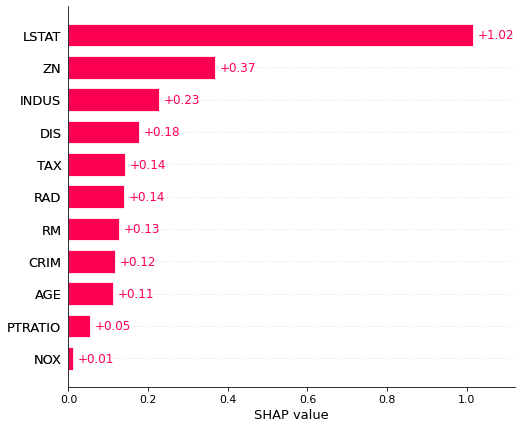

In [198]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

In [199]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

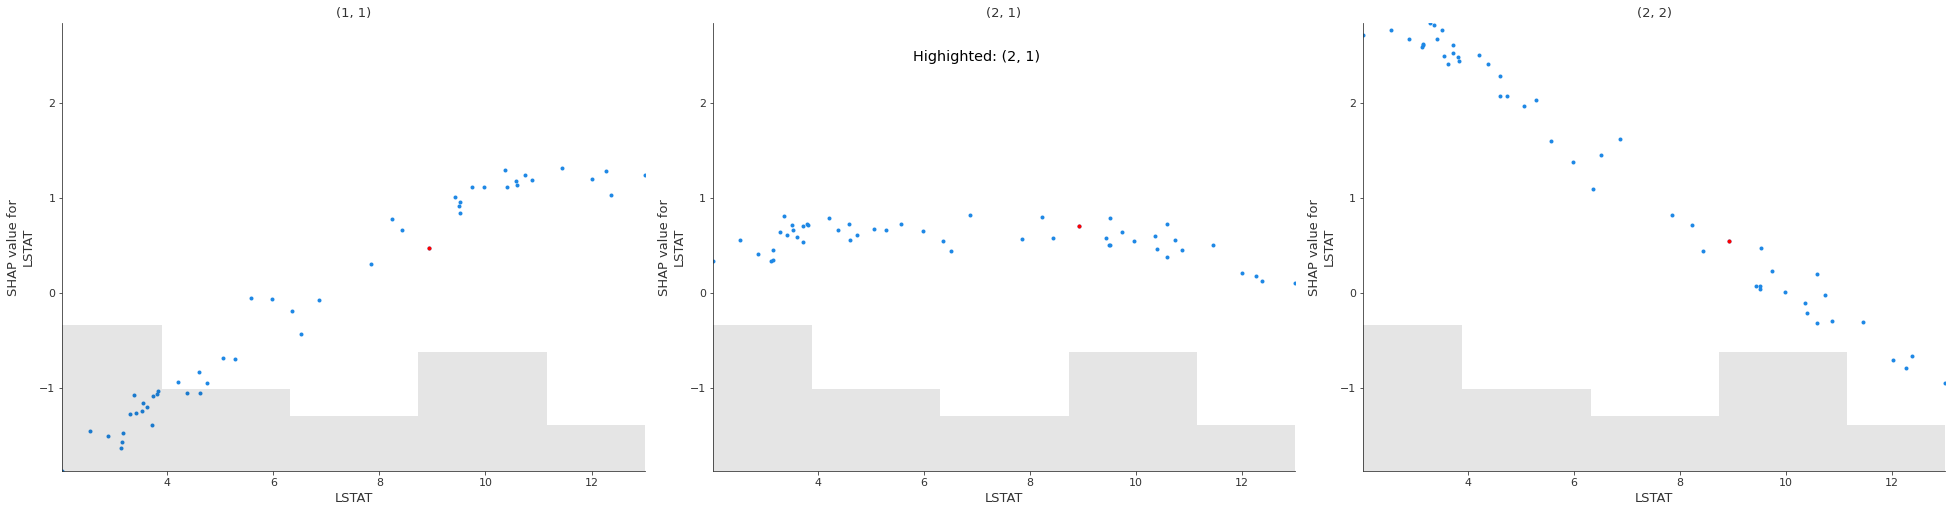

In [200]:
plot_feature('LSTAT')

In [216]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 8.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",1.0,NaN
"(2, 2)",NaN,1.0


In [211]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 9.1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1.0
"(2, 1)",1.0,NaN


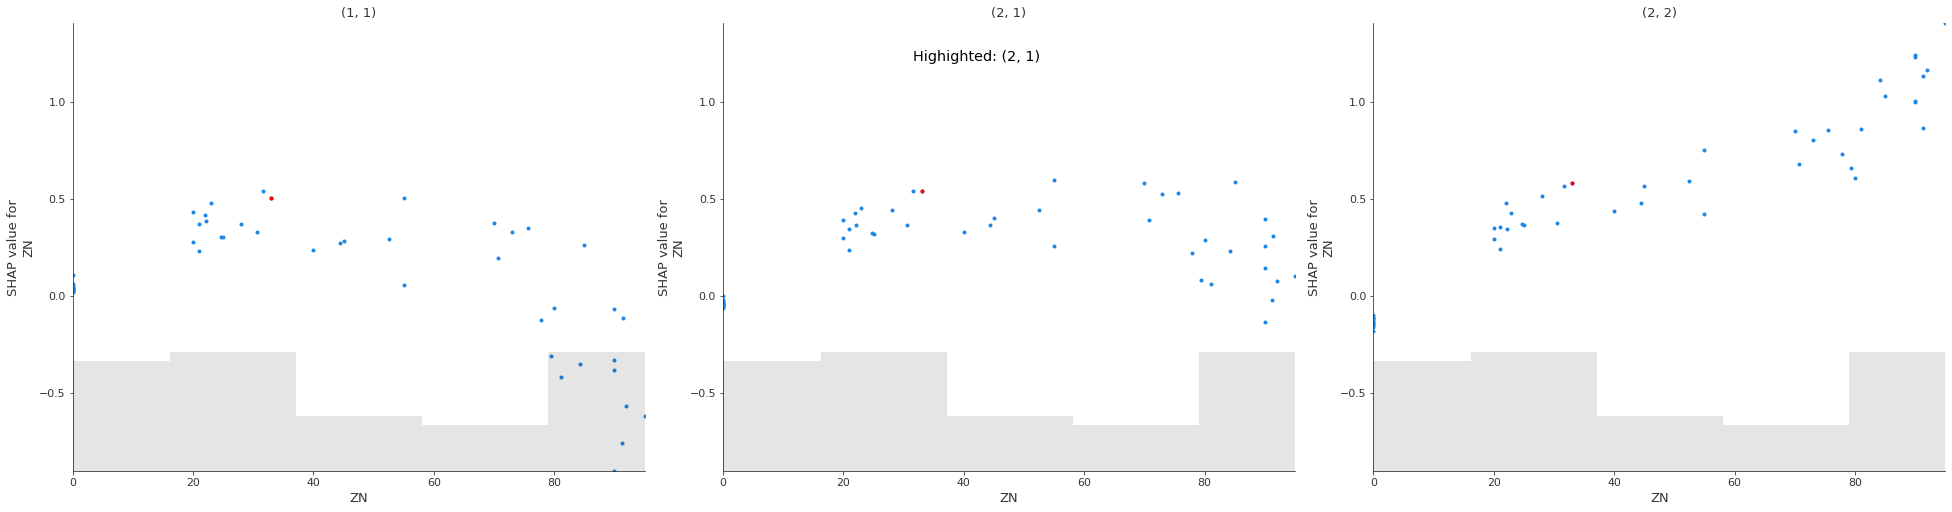

In [217]:
plot_feature('ZN')

In [226]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 62
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",1.0,NaN
"(2, 2)",NaN,1.0


### Cluster c3

In [227]:
cluster, shap_values, pred_classes = get_cluster('c3')
classes = ['(1, 1)', '(2, 1)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c3,0,0,0,0,2,0,0,2,22


#### Global Effects

Instances in this cluster are characterized by:
- LSTAT ranges up to 9.5
- ZN is 0
- INDUS ranges from 11.9 to 19.6
- CRIM ranges up to 9.2
- TAX ranges from 273 upwards
- DIS ranges up to 3.4
- $AGE=1$ is underrepresented, $AGE=0$ is not present

That means:
- LSTAT has a high increasing effect on the outcome of class $(2,1)$ which decreases above this range, while the increasing effect on $(1,1)$ reaches its maximum at approx. 12.
- ZN has a decreasing effect on both $(2,1)$ and $(2,2)$ between 0 and -0.5. Up until approx. 80, the effect switches for both to increasing the outcome but above 80, it increases further for $(2,2)$.

Summary:
For the instances where A predicts 2 and B 1 and that have the characteristics described above, the differences persist up to a value of $LSTAT=9.6$ where A changes to 1, or up to a value of $ZN=83$ where B changes to 2.

In [228]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,6.099571,0.0,18.312692,5.287492,570.918496,6.593802,17.338365,1.630418,1.961538,18.558474,0.640270
std,2.549430,0.0,1.469981,3.108343,135.687864,0.888132,9.376811,0.565362,0.196116,2.585555,0.064037
min,1.763949,0.0,11.930000,0.109590,273.000000,3.561000,1.000000,1.137912,1.000000,14.700000,0.532000
25%,3.636254,0.0,18.100000,1.859495,403.000000,6.186526,5.000000,1.179360,2.000000,14.830081,0.605000
50%,6.515205,0.0,18.100000,5.742859,666.000000,6.454000,24.000000,1.346370,2.000000,20.200000,0.631000
75%,8.570682,0.0,19.544996,8.307162,666.000000,7.019117,24.000000,1.979770,2.000000,20.200000,0.642544
max,9.530000,0.0,19.580000,9.232300,666.000000,7.905616,24.000000,3.410600,2.000000,21.000000,0.871000


In [229]:
df['AGE'].value_counts()

2.0    25
1.0     1
Name: AGE, dtype: int64

In [232]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 9.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,2.0
"(2, 1)",2.0,NaN


In [238]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 83
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",2.0,NaN
"(2, 2)",NaN,2.0


#### Local Effects

Explanations:
- With decreasing values of LSTAT, the increasing effect on the outcome of $(2,1)$ is constant, but on $(2,2)$, it increases. This effect is strong enough to change the prediction of the instance classified $(2,1)$ to $(2,2)$. The same applies to increasing values and $(1,1)$.

In [239]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
4,7.12,0.0,18.10,4.55587,666.0,3.561,24.0,1.6132,2.0,20.2,0.718
9,6.48,0.0,11.93,0.10959,273.0,6.794,1.0,2.3889,2.0,21.0,0.573


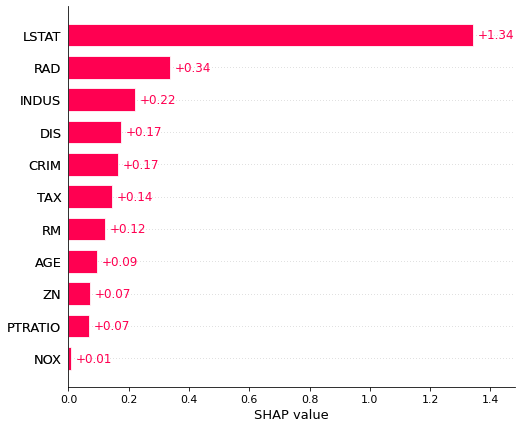

In [240]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

In [241]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

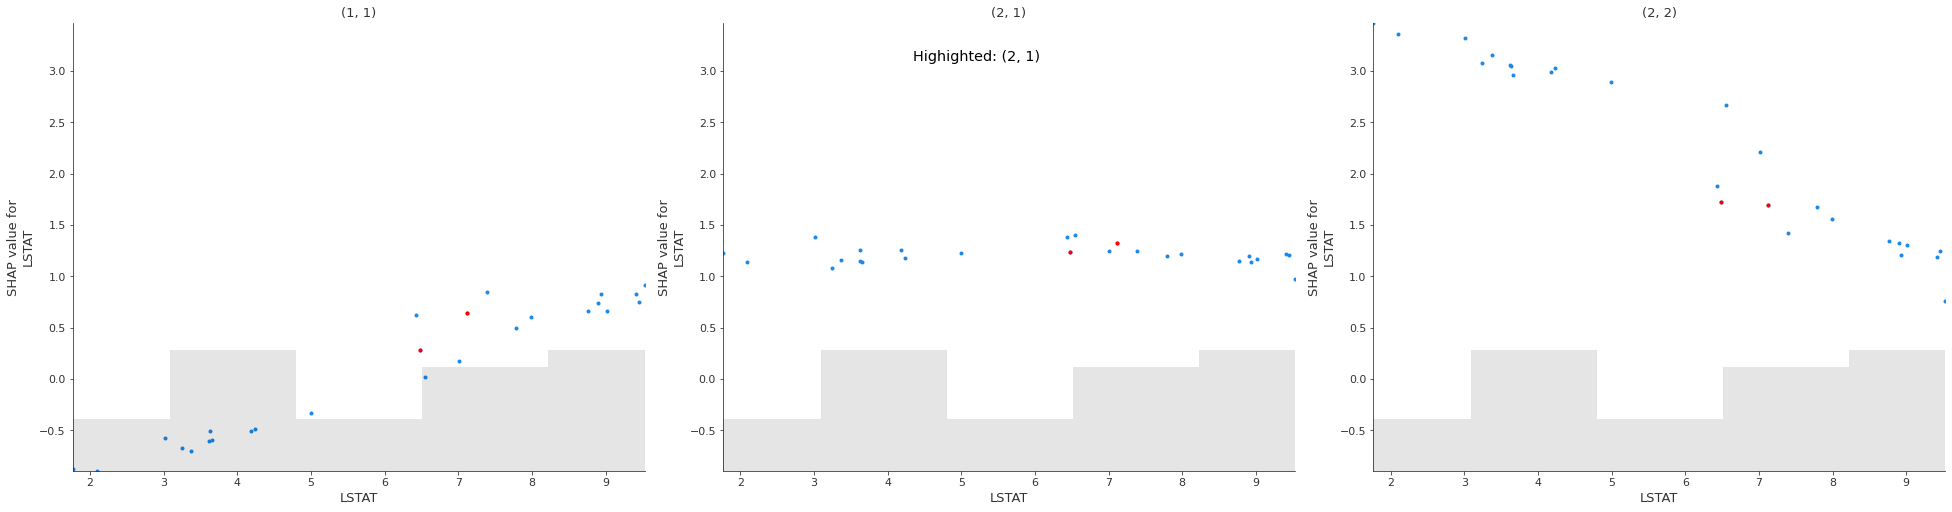

In [242]:
plot_feature('LSTAT')

In [249]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 7.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,2.0
"(2, 1)",2.0,NaN


In [255]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 5.9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",2.0,NaN
"(2, 2)",NaN,2.0


The two instances classified differently are not very similar within the cluster.

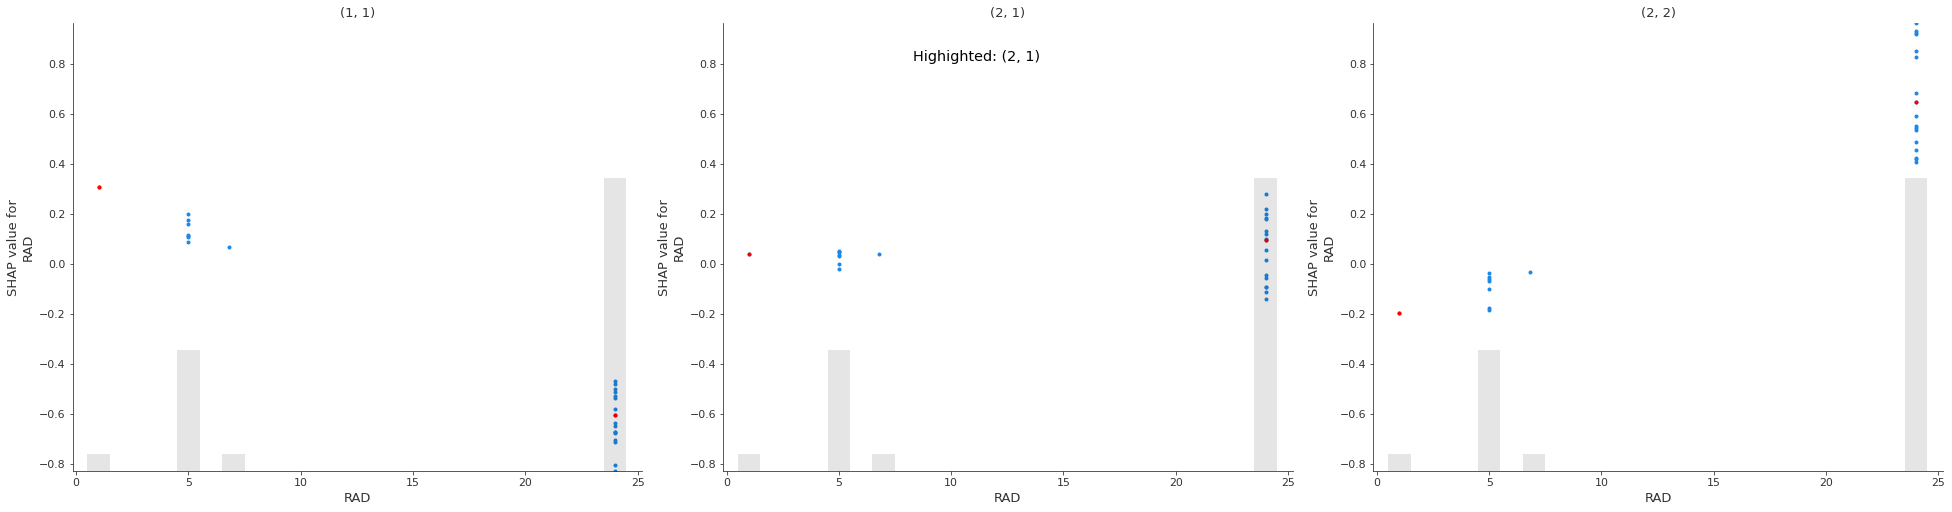

In [266]:
plot_feature('RAD')

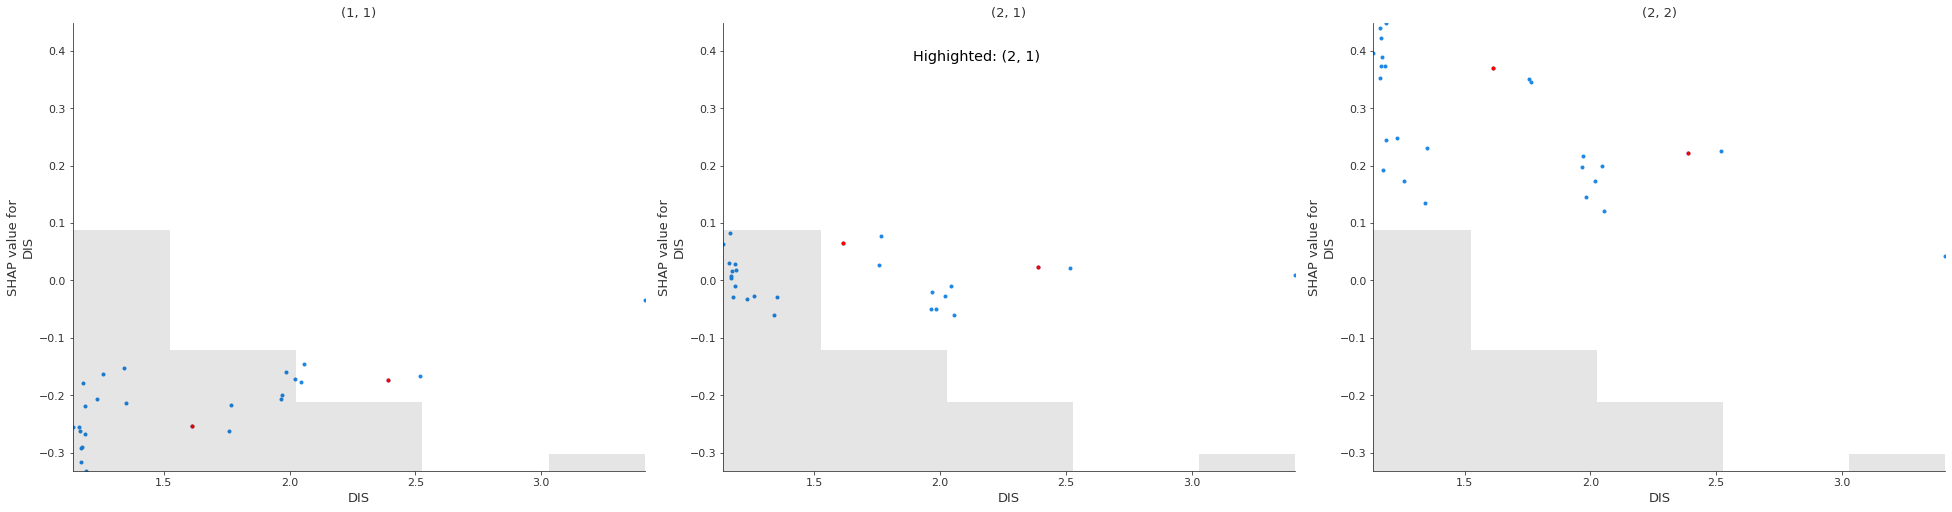

In [258]:
plot_feature('DIS')

DIS shows an effect, but it's not strong enough to change the predictions of both instances.

In [260]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['DIS'] = 1.14
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",2.0,1
"(2, 2)",NaN,1


In [259]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['DIS'] = 3.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1
"(2, 1)",2.0,1


Since it's particularly hard finding a second explanation besides LSTAT, I will further split this cluster to investigate in more detail.

#### Splitting the Cluster Further

Increasing n to 42 splits cluster c3 into two clusters, each with one instance classified differently.

In [277]:
n_clusters = 42
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c2,0,0,0,0,2,0,0,1,9
c8,0,0,0,0,4,1,0,0,2
c14,0,0,0,0,2,0,0,1,6
c15,0,0,0,0,0,0,0,1,9
c27,0,2,0,0,0,0,0,0,0
c28,1,1,0,0,0,0,0,0,0
c29,0,1,0,0,2,0,0,0,0
c36,0,4,0,0,0,0,0,0,0
c38,0,2,0,0,6,0,0,0,0
c39,1,2,0,0,0,0,0,0,0


##### Cluster c14 Local Effects

In [279]:
cluster, shap_values, pred_classes = get_cluster('c14')
classes = ['(1, 1)', '(2, 1)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c14,0,0,0,0,2,0,0,1,6


Explanations (continued):
- With increasing values of INDUS, the increasing effect on the outcome of $(2,1)$ shrinks, but on $(1,1)$, it increases.

In [282]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,9.000000,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000
mean,4.261973,0.0,18.714443,1.528496,391.320099,7.301891,4.755275,1.994577,2.0,15.457814,0.631273
std,2.033814,0.0,2.544587,0.641121,45.126596,0.679218,1.528558,0.184598,0.0,2.085432,0.090536
min,1.763949,0.0,11.930000,0.109590,273.000000,6.066000,1.000000,1.757300,2.0,14.700000,0.573000
25%,3.015154,0.0,19.580000,1.342840,403.000000,6.794000,5.000000,1.966101,2.0,14.700000,0.605000
50%,3.629993,0.0,19.580000,1.529545,403.000000,7.544927,5.000000,1.983372,2.0,14.700000,0.605000
75%,6.430000,0.0,19.580000,1.820091,403.000000,7.842626,5.000000,2.044943,2.0,14.700000,0.605000
max,7.390000,0.0,19.580000,2.438611,427.880887,7.905616,6.797479,2.388900,2.0,21.000000,0.871000


In [283]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
3,6.48,0.0,11.93,0.10959,273.0,6.794,1.0,2.3889,2.0,21.0,0.573


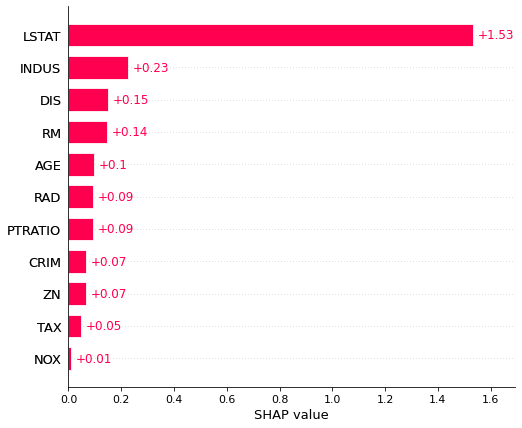

In [284]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

In [285]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

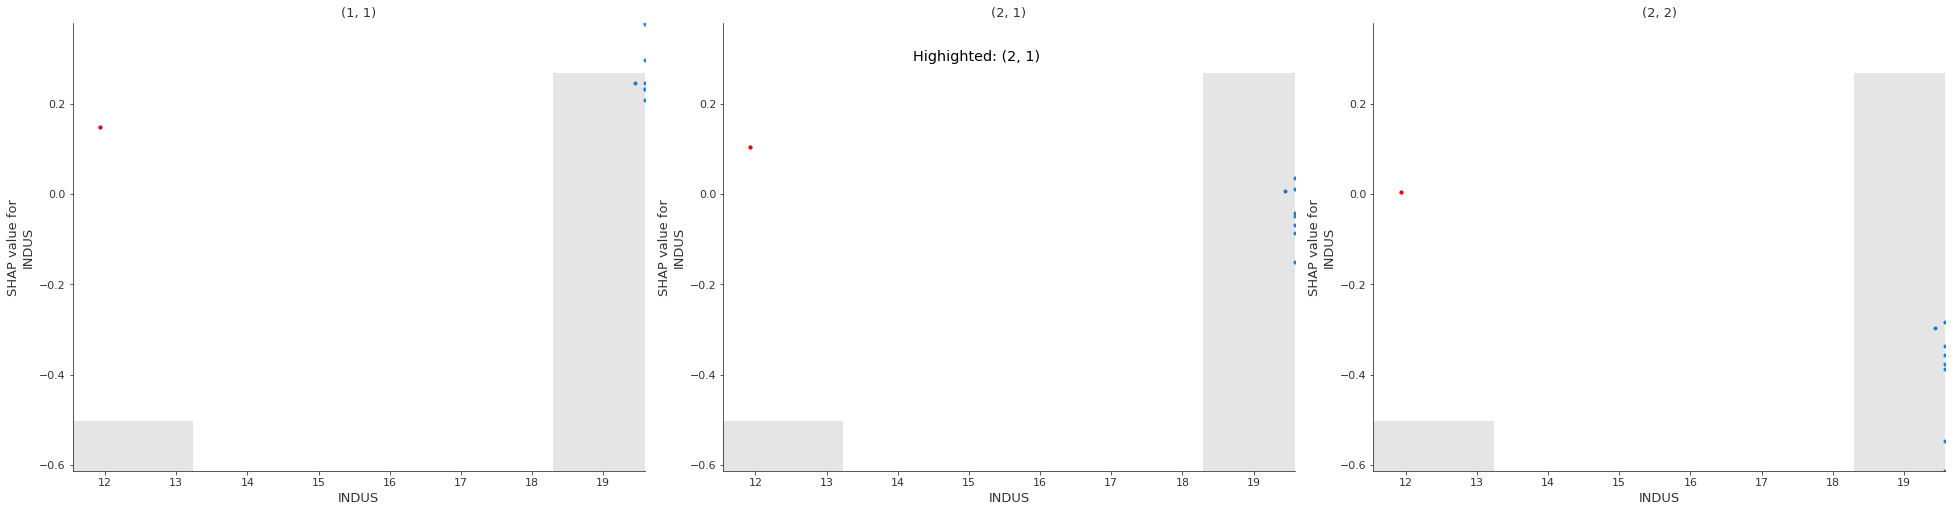

In [286]:
plot_feature('INDUS')

In [291]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 17
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,1.0
"(2, 1)",1.0,NaN


##### Cluster c15 Local Effects

In [293]:
cluster, shap_values, pred_classes = get_cluster('c15')
classes = ['(2, 1)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c15,0,0,0,0,0,0,0,1,9


Explanations (continued):
- With increasing values of RM, the effect on the outcome of $(2,1)$ is constant and close to 0, but on $(2,2)$, it increases.

In [294]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
count,10.000000,10.0,10.0,10.000000,10.0,10.000000,10.0,10.000000,10.000000,1.000000e+01,10.000000
mean,5.621048,0.0,18.1,6.124755,666.0,6.256169,24.0,1.625922,1.900000,2.020000e+01,0.650856
std,1.861307,0.0,0.0,1.110997,0.0,1.000399,0.0,0.747599,0.316228,3.744889e-15,0.061753
min,3.243336,0.0,18.1,4.541920,666.0,3.561000,24.0,1.168909,1.000000,2.020000e+01,0.532000
25%,3.800009,0.0,18.1,5.550424,666.0,6.251351,24.0,1.198123,2.000000,2.020000e+01,0.631000
50%,5.774050,0.0,18.1,5.986817,666.0,6.510631,24.0,1.300428,2.000000,2.020000e+01,0.641352
75%,7.092500,0.0,18.1,7.047037,666.0,6.756562,24.0,1.547665,2.000000,2.020000e+01,0.659013
max,7.988588,0.0,18.1,7.817689,666.0,7.061000,24.0,3.410600,2.000000,2.020000e+01,0.770000


In [295]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,TAX,RM,RAD,DIS,AGE,PTRATIO,NOX
2,7.12,0.0,18.1,4.55587,666.0,3.561,24.0,1.6132,2.0,20.2,0.718


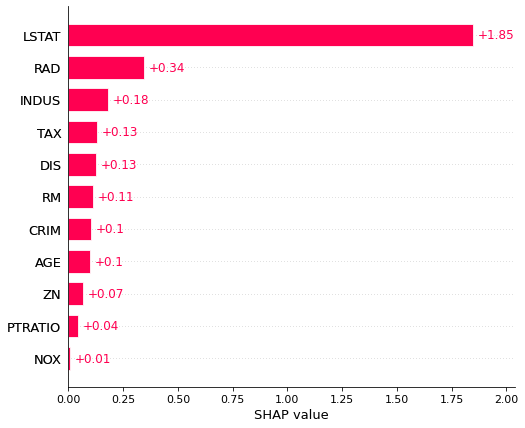

In [296]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

In [297]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

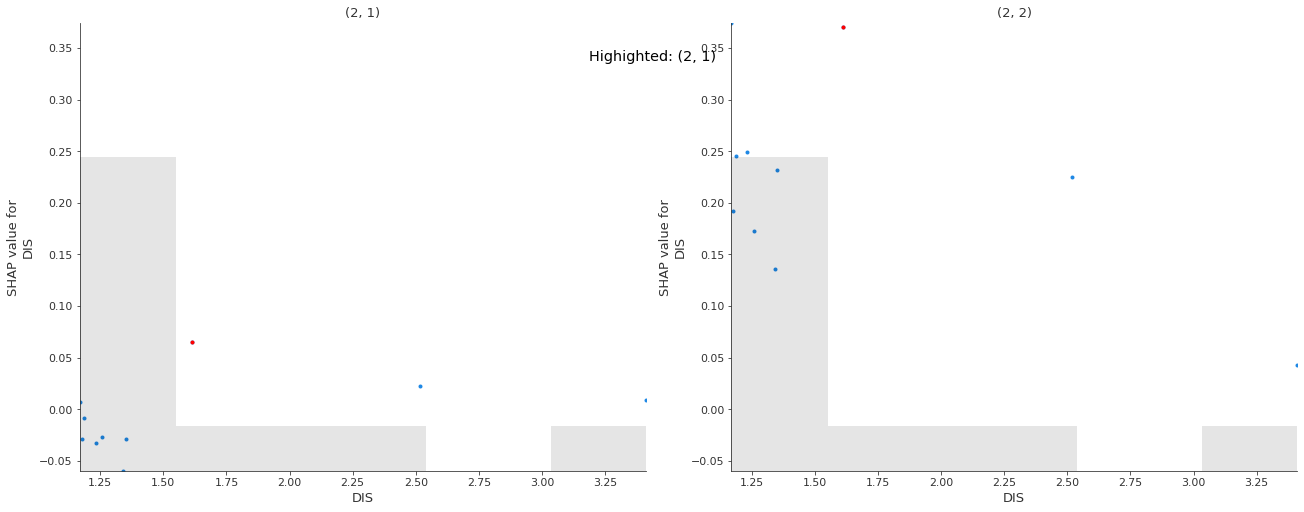

In [300]:
plot_feature('DIS')

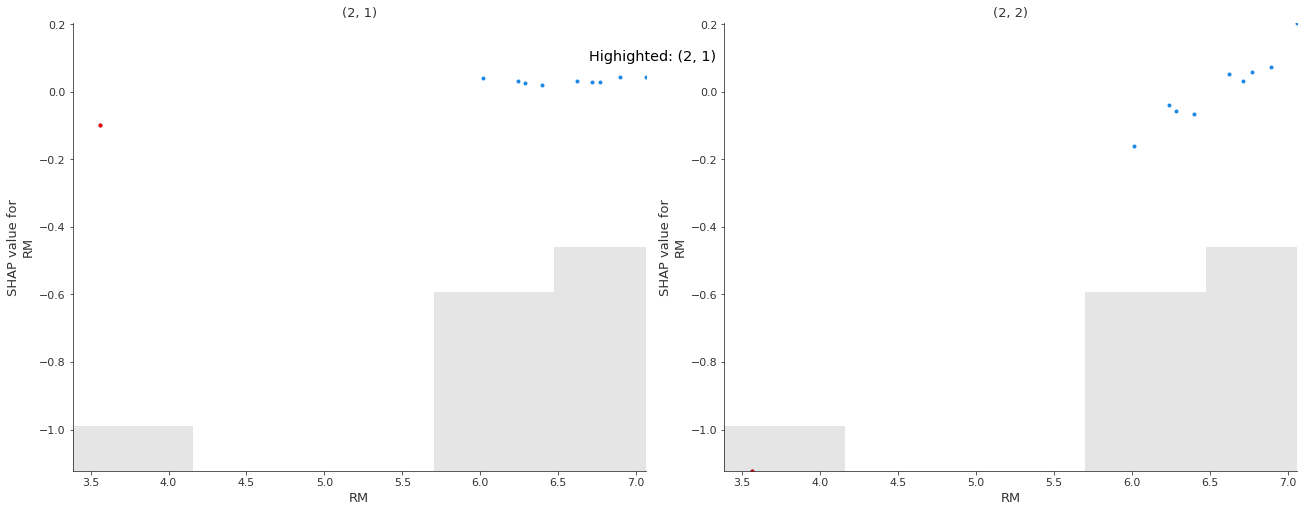

In [307]:
plot_feature('RM')

In [315]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['RM'] = 4.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",1.0,NaN
"(2, 2)",NaN,1.0
